<a href="https://colab.research.google.com/github/marco-siino/Enhanced-Home-Appliance-Scheduling-with-GPT/blob/main/Mistral%207B%20Quantized/Mistral_Quantized_Energy_Cost_Optimization_Nov2014_MSiino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download model and libraries.

Installing dependencies. You might need to tweak the CMAKE_ARGS for the `llama-cpp-python` pip package.

In [ ]:
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF
!CMAKE_ARGS="-DLLAMA_CUBLAS=on " pip install 'llama-cpp-python>=0.1.79' --force-reinstall --upgrade --no-cache-dir
# For download the models
!pip install huggingface_hub
!pip install datasets
!pip install py7zr

from datasets import load_dataset
from datetime import datetime, timedelta
from huggingface_hub import hf_hub_download
from py7zr import unpack_7zarchive
import matplotlib.pyplot as plt
import json
import re
import datasets
import random
import numpy as np
import tqdm.notebook as tqdm
import tensorflow as tf
import os
import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 168.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 127.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 170.1 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.64-cp310-cp310-linux_x86_64.whl size=39387070 sha256=04c95164401574f1716d6361661198547f5c8127f2e179e767a20697895e7f41
  Stored in directory: /tmp/pip-ephem-wheel-cache-uevairys/wheels/4a/69/6b/2fb423c0e39b66cc7f9b84ea837dbdc1eee8ea5f624e3eaeb6
Successfully built llama-cpp-python
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
  

Downloading an instruction-finetuned Mistral model.

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

# This config has been tested on an RTX 3080 (VRAM of 16GB).
# you might need to tweak with respect to your hardware.
from llama_cpp import Llama
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=4, #16, # CPU cores
    n_batch=800, #8000, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=8192, # Context window
    logits_all=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

# Get the dataset.

In [ ]:
def download_and_extract(url, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        # Save the downloaded file
        filename = os.path.join(output_dir, "archive.7z")
        with open(filename, "wb") as f:
            f.write(response.content)

        # Extract the contents of the archive
        with open(filename, 'rb') as f:
            unpack_7zarchive(f, output_dir)

        print("Extraction completed.")
    else:
        print("Failed to download the file.")

# Example usage:
url = "https://pureportal.strath.ac.uk/files/52873459/Processed_Data_CSV.7z"
output_directory = "extracted_contents"
download_and_extract(url, output_directory)

Extraction completed.


# DNE (Doesn't Need to be Executed) - Dataset structure.
Each CSV file corresponds to a House. For each house there are always 9 appliances. The corresponding description of each appliance is reported below.

House 1

0.Aggregate, 1.Fridge, 2.Chest Freezer, 3.Upright Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Computer Site, 8.Television Site, 9.Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor

House 2

0.Aggregate, 1.Fridge-Freezer, 2.Washing Machine, 3.Dishwasher, 4.Television,
5.Microwave, 6.Toaster, 7.Hi-Fi, 8.Kettle, 9.Oven Extractor Fan
	!NOTES

House 3

0.Aggregate, 1.Toaster, 2.Fridge-Freezer, 3.Freezer, 4.Tumble Dryer,
5.Dishwasher, 6.Washing Machine, 7.Television, 8.Microwave, 9.Kettle
	!NOTES

House 4

0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine (1),
5.Washing Machine (2), 6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		6.a Desktop Computer
		6.b Computer Monitor
		6.c Scanner
		6.d Printer
		6.e Router
		6. Change in signature 01/02/2015
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7. Change in signature 19/12/2014

House 5

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Combination Microwave, 8.Kettle, 9.Toaster
	!NOTES
		2. Dehumidifier added on 21/11/2014
		5.a Desktop Computer
		5.b Computer Monitor
		5.c Printer
		5.d Speakers
		5. Change in signature 27/01/2015
		6.a Television w/DVD Player
		6.b Set-top Box
		6.c Games Console

House 6

0.Aggregate, 1.Freezer (Utility Room), 2.Washing Machine, 3.Dishwasher, 4.MJY Computer,
5.Television Site, 6.Microwave, 7.Kettle, 8.Toaster, 9.PGM Computer
	!NOTES
		4.a Desktop Computer
		4.b Computer Monitor
		4.c Computer Monitor
		4.d Printer
		5.a Television
		5.b Set-top Box
		5.c PC
		5.d DVD Player
		9.a Desktop Computer
		9.b Computer Monitor
		9.c Printer
		9.d Shredder

House 7

0.Aggregate, 1.Fridge, 2.Freezer (Garage), 3.Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Toaster, 9.Kettle
	!NOTES
		3. Change in signature 24/11/13
		6. Change in signature 20/05/14
		7.a Television
		7.b Speakers
		7.c Telephone

House 8

0.Aggregate, 1.Fridge, 2.Freezer, 3.Dryer, 4.Washing Machine,
5.Toaster, 6.Computer, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		1. Change in Fridge Nov 6th
		5.a Toaster
		5.b DAB Radio
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7.d Sound Bar

House 9

0.Aggregate, 1.Fridge-Freezer, 2.Washer Dryer, 3.Washing Machine, 4.Dishwasher,
5.Television Site, 6.Microwave, 7.Kettle, 8.Hi-Fi, 9.Electric Heater
	!NOTES
		5.a Television
		5.b Sky Box
		5.c DVD Player

House 10

0.Aggregate, 1.Magimix (Blender), 2.Freezer, 3.Chest Freezer (In Garage), 4.Fridge-Freezer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Microwave, 9. Kenwood KMix
	!NOTES
		1. Changed from Fridge to Blender on 17/06/2014
		2. Changed from Freezer to Toaster on 25/06/2014.
		3. Post April 2015, included a second Freezer (both located in Garage)
		4. Changed from Whirlpool ART 500-9/G/1 to AEG SKZ71800F0 March 2015 (Both Fridge-Freezer)
		7.a. TV
		7.b. DVD Player
		7.c. Set-top Box
		7.d. Router
		7.e. Network storage External power supply
		7.f. Laptop external power supply

House 11

0.Aggregate, 1.Fridge, 2.Fridge-Freezer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Microwave, 7.Kettle, 8.Router, 9.Hi-Fi
	!NOTES
		0. Aggregate is affected by Solar Panels.
		4. Possible dishwasher replacement

House 12

0.Aggregate, 1.Fridge-Freezer, 2.Television Site(Lounge), 3.Microwave, 4.Kettle,
5.Toaster, 6.Television Site(Bedroom), 7.Not Used, 8.Not Used, 9.Not Used
	!NOTES

House 13

0.Aggregate, 1.Television Site, 2.Unknown, 3.Washing Machine, 4.Dishwasher,
5.Tumble Dryer, 6.Television Site, 7.Computer Site, 8.Microwave, 9.Kettle
	!NOTES
		1.a Television
		1.b Xbox
		1.c Wii
		2. Has a device attached which was not recorded.
		5. Signature changes with no mention of devices attached.
		6.a Television
		6.b Computer
		6.c Current Cost
		7.a Laptop Dock
		7.b Camera System (July-Aug 2014)

House 15

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle , 9.Toaster
	!NOTES
		5.a Desktop Computer
		5.b Printer
		6.a Television
		6.b Xbox
		6.c Set-top Box

House 16

0.Aggregate, 1.Fridge-Freezer (1), 2.Fridge-Freezer (2), 3.Electric Heater (1)?,
4.Electric Heater (2), 5.Washing Machine, 6.Dishwasher, 7.Computer Site,
8.Television Site, 9.Dehumidifier/Heater
	!NOTES
		8.a Television
		8.b DVD/Blue-ray Player
		8.c Wii
		8.d Speakers

House 17

0.Aggregate, 1.Freezer (Garage), 2.Fridge-Freezer, 3.Tumble Dryer (Garage), 4.Washing Machine,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle, 9.Plug Site (Bedroom)
	!NOTES
		1. Was replaced 1 month before recording stopped with smaller capacity Freezer.
		2. Was replaced mid May 2015.
		5.a Desktop
		5.b Computer Monitor
		5.c Computer Monitor
		5.d Printer
		8.a Kettle
		8.b Toaster & Misc (Occasionally plugged in)
		9.a Television
		9.b Laptop
		9.c Hair Dryer
		9.d Phone Charger

House 18

0.Aggregate, 1.Fridge(garage), 2.Freezer(garage), 3.Fridge-Freezer,
4.Washer Dryer(garage), 5.Washing Machine, 6.Dishwasher, 7.Desktop Computer,
8.Television Site, 9.Microwave
	!NOTES
		8.a Television
		8.b DVD Player
		8.c Sky Box
		8.d Speakers
		8.e Lamp
		8.f HiFi

House 19

0.Aggregate, 1.Fridge & Freezer, 2.Washing Machine, 3.Television Site, 4.Microwave,
5.Kettle, 6.Toaster, 7.Bread-maker, 8.Lamp (80Watts), 9.Hi-Fi
	!NOTES
		1. This plug has a fridge AND a freezer attached on the same IAM
		3.a Television
		3.b DVD Player

House 20

0.Aggregate, 1.Fridge, 2.Freezer, 3.Tumble Dryer, 4.Washing Machine, 5.Dishwasher,
6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES

House 21

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine,
4.Dishwasher, 5.Food Mixer, 6.Television, 7.Kettle/Toaster, 8.Vivarium, 9.Pond Pump
	!NOTES
		House 21 Aggregate is affected by Solar Panels.

# Make a dictionary for House 1. (Ex. Key-Value -> Fridge-Appliance1)

In [ ]:
appliances = [
    "Fridge", "Chest Freezer", "Upright Freezer", "Tumble Dryer",
    "Washing Machine", "Dishwasher", "Computer Site", "Television Site",
    "Electric Heater"
]

appliances_dict = {f"Appliance{i+1}": appliance for i, appliance in enumerate(appliances)}


In [ ]:
print(appliances_dict)

{'Appliance1': 'Fridge', 'Appliance2': 'Chest Freezer', 'Appliance3': 'Upright Freezer', 'Appliance4': 'Tumble Dryer', 'Appliance5': 'Washing Machine', 'Appliance6': 'Dishwasher', 'Appliance7': 'Computer Site', 'Appliance8': 'Television Site', 'Appliance9': 'Electric Heater'}


# Make the dataframe from the dataset.

In [ ]:
import pandas as pd

def read_csv_to_dataframe(csv_file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file)
    return df

# Example usage:
dataframe = read_csv_to_dataframe("extracted_contents/House_1.csv")
print(dataframe)


                        Time        Unix  Aggregate  Appliance1  Appliance2  \
0        2013-10-09 13:06:17  1381323977        523          74           0   
1        2013-10-09 13:06:31  1381323991        526          75           0   
2        2013-10-09 13:06:46  1381324006        540          74           0   
3        2013-10-09 13:07:01  1381324021        532          74           0   
4        2013-10-09 13:07:15  1381324035        540          74           0   
...                      ...         ...        ...         ...         ...   
6960003  2015-07-10 11:56:05  1436529365        187           0          45   
6960004  2015-07-10 11:56:12  1436529372        185           0          45   
6960005  2015-07-10 11:56:18  1436529378        181           0          45   
6960006  2015-07-10 11:56:25  1436529385        186           0          45   
6960007  2015-07-10 11:56:32  1436529392        182           0          45   

         Appliance3  Appliance4  Appliance5  Applia

# DNE - With the next cell it is possible to see the working load of a fridge. The pattern is quite regular.

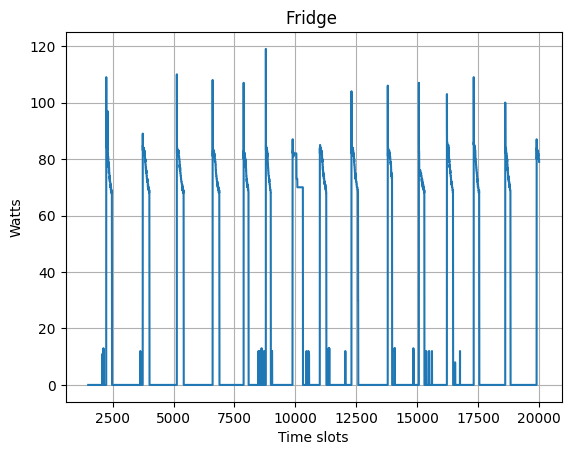

In [ ]:
import matplotlib.pyplot as plt

# Plot all the values in 'Column1'
dataframe['Appliance1'][1500:20000].plot()

# Add labels and title
plt.xlabel('Time slots')
plt.ylabel('Watts')
plt.title('Fridge ')
plt.grid("True")

# Show the plot
plt.show()

# Store the average consumptions of each appliance in the house.

In [ ]:
def calculate_avg_appliance_consumption(appliance):

  # Find the maximum and minimum non-zero values
  max_non_zero = dataframe[appliance][dataframe[appliance] != 0].max()
  min_non_zero = dataframe[appliance][dataframe[appliance] != 0].min()

  # Filter the DataFrame to include only values between the maximum and minimum
  filtered_values = dataframe[(dataframe[appliance] > min_non_zero) & (dataframe[appliance] < max_non_zero)][appliance]

  # Calculate the average of the filtered values
  average_between_non_zero = filtered_values.mean()

  return average_between_non_zero

In [ ]:
# Save the average consumption of any device in a list.
avg_appliances_consumptions = {}

for i in range(1, len(appliances_dict)+1):
  avg_appliances_consumptions[appliances_dict["Appliance"+str(i)]]=calculate_avg_appliance_consumption("Appliance"+str(i))
  #avg_appliances_consumptions.append((appliances_dict["Appliance"+str(i)],calculate_avg_appliance_consumption("Appliance"+str(i))))

print(avg_appliances_consumptions)


{'Fridge': 75.79845793092484, 'Chest Freezer': 48.08923243274837, 'Upright Freezer': 72.21469605959662, 'Tumble Dryer': 472.6271729522687, 'Washing Machine': 513.3838271002094, 'Dishwasher': 1379.0888017181703, 'Computer Site': 29.738480373322528, 'Television Site': 31.700847769012388, 'Electric Heater': 1007.2853867493128}


# Sostituisco ora tutti i valori in watts presenti con ON e OFF.

In [ ]:
discretized_dataframe = dataframe
for i in range(1,len(appliances_dict)+1):
  discretized_dataframe["Appliance"+str(i)] = np.where(dataframe["Appliance"+str(i)] != 0, 'ON', 'OFF')

In [ ]:
print(discretized_dataframe)

                        Time        Unix  Aggregate Appliance1 Appliance2  \
0        2013-10-09 13:06:17  1381323977        523         ON        OFF   
1        2013-10-09 13:06:31  1381323991        526         ON        OFF   
2        2013-10-09 13:06:46  1381324006        540         ON        OFF   
3        2013-10-09 13:07:01  1381324021        532         ON        OFF   
4        2013-10-09 13:07:15  1381324035        540         ON        OFF   
...                      ...         ...        ...        ...        ...   
6960003  2015-07-10 11:56:05  1436529365        187        OFF         ON   
6960004  2015-07-10 11:56:12  1436529372        185        OFF         ON   
6960005  2015-07-10 11:56:18  1436529378        181        OFF         ON   
6960006  2015-07-10 11:56:25  1436529385        186        OFF         ON   
6960007  2015-07-10 11:56:32  1436529392        182        OFF         ON   

        Appliance3 Appliance4 Appliance5 Appliance6 Appliance7 Appliance8  

# La cella seguente contiene la funzione che riceve in input il giorno e l'appliance e in output restituisce tutti gli intervalli di funzionamento, ovvero orari (inizio e fine) di ON.

In [ ]:
def get_daily_appliance_operating_times(df,day,appliance):
  df['timestamp'] = pd.to_datetime(df['Time'])
  day_to_filter = day

  # Parse the input date string into a datetime object
  date_obj = datetime.strptime(day, '%Y-%m-%d')
  # Get the day of the week (e.g., "Monday")
  day_of_week = date_obj.strftime('%A')  # Return the day name directly

  # Filter rows related to the specific day
  filtered_df = df[df['timestamp'].dt.date == pd.to_datetime(day_to_filter).date()]
  filtered_df.reset_index(drop=True, inplace=True)

  if filtered_df.empty:
    prompt= "The day you have selected is not in the dataset."

  else:
    # Now manage the case of the appliance either ON or OFF all day long.
    if (filtered_df[appliance] == 'ON').all():
      # Case of an appliance always ON during the current day.
      prompt += "From: 00:00:00 To: 23:59:59\n"+"\n***\n\n"
      return prompt
    if (filtered_df[appliance] == 'OFF').all():
      # Case of an appliance always OFF during the current day.
      prompt = "During the day: " +day+" ("+ day_of_week+"), the "+appliances_dict[appliance] +" was never ON.\n"+"\n***\n\n"
      return prompt

    prompt = "During the day: " +day+" ("+ day_of_week+"), the "+appliances_dict[appliance] +" was ON at these times:\n"

    closed_interval = True

    # Iterate over the DataFrame
    for i in range(0, len(filtered_df)):
      if i==0:
        if filtered_df[appliance][i] == 'ON':
          #The appliance is ON since the day before.
          prompt += "From: 00:00:00 "
          closed_interval = False
        continue

      if filtered_df[appliance][i - 1] == 'ON' and filtered_df[appliance][i] == 'OFF':
        prompt += "To: "+ datetime.strptime(filtered_df.loc[i,'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + "\n"
        closed_interval = True
        continue

      if filtered_df[appliance][i - 1] == 'OFF' and filtered_df[appliance][i] == 'ON':
        prompt += "From: "+ datetime.strptime(filtered_df.loc[i,'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " "
        closed_interval = False
        continue

    if closed_interval==False:
      prompt += "To: 23:59:59\n"

  prompt +="\n***\n\n"

  return prompt

In [ ]:
print(get_daily_appliance_operating_times(dataframe,'2013-11-18','Appliance1'))

During the day: 2013-11-18 (Monday), the Fridge was ON at these times:
From: 00:00:00 To: 00:03:05
From: 01:46:08 To: 02:16:06
From: 04:07:06 To: 04:37:35
From: 06:35:37 To: 07:06:06
From: 07:17:22 To: 07:17:40
From: 07:21:35 To: 07:21:53
From: 07:23:19 To: 07:23:39
From: 07:47:05 To: 07:47:20
From: 08:29:22 To: 08:30:35
From: 08:47:43 To: 09:07:06
From: 11:04:19 To: 11:34:19
From: 12:10:50 To: 12:11:06
From: 13:19:35 To: 13:19:51
From: 13:34:06 To: 14:05:12
From: 16:05:20 To: 16:37:19
From: 16:44:54 To: 16:45:09
From: 16:45:35 To: 16:45:54
From: 18:29:10 To: 19:03:06
From: 19:05:38 To: 19:06:20
From: 19:32:35 To: 19:33:06
From: 19:34:19 To: 19:34:38
From: 19:37:35 To: 19:38:06
From: 20:10:35 To: 20:11:08
From: 20:12:35 To: 20:13:35
From: 20:17:06 To: 20:46:19
From: 22:28:40 To: 22:59:06

***




# Grazie al prossimo blocco di celle calcolo il costo totale per un giorno.

In [ ]:
# La funzione in questa cella conta quante frazioni di ora ci sono in un intervallo di costo.
def count_hours_in_range(interval_start, interval_end, range_start, range_end):
    original_is = interval_start
    original_ie = interval_end
    original_rs = range_start
    original_re = range_end

    interval_start = datetime.strptime(interval_start, "%H:%M:%S")
    interval_end = datetime.strptime(interval_end, "%H:%M:%S")
    range_start = datetime.strptime(range_start, "%H:%M:%S")
    range_end = datetime.strptime(range_end, "%H:%M:%S")

    # SPECIAL CASE: the interval crosses the midnight (00:00:00) of two consecutive days, apply the following if:
    if interval_start > interval_end:
      # Il problema va scomposto...Bisogna dividere l'intervallo in due (A e B). Ovvero quello prima (A) e quello dopo la mezzanotte (B).

      # Conto le ore nel primo e nel secondo intervallo all'interno del medesimo range:
      hours_in_A = count_hours_in_range(original_is,"23:59:59",original_rs,original_re)
      hours_in_B = count_hours_in_range("00:00:00",original_ie,original_rs,original_re)

      return(hours_in_A+hours_in_B)

    # Here all the conditions for an interval that doesnt cross two days.
    # If the entire interval falls within the range
    if range_start <= interval_start and interval_end <= range_end:
        return (interval_end - interval_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval completely covers the range
    elif interval_start <= range_start and interval_end >= range_end:
        return (range_end - range_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval and the range partially overlap
    elif interval_start <= range_end and interval_end >= range_start:
        start = max(interval_start, range_start)
        end = min(interval_end, range_end)
        return (end - start).total_seconds() / 3600  # Convert seconds to hours
    # If there is no overlap
    else:
        return 0

# Example usage:
interval_start = "23:00:00"
interval_end = "09:40:00"
range_start = "19:00:00"
range_end = "23:59:59"

hours_counted = count_hours_in_range(interval_start, interval_end, range_start, range_end)
print("Hours counted within the range:", hours_counted)

Hours counted within the range: 0.9997222222222222


In [ ]:
f1_cost= 0.07138
f23_cost= 0.06999

# La funzione riceve in input tutti gli intervalli e stampa il costo del singolo intervallo oltre a quello finale.
def calculate_daily_cost(input_string,day,appliance):
    global avg_appliances_consumptions
    total_cost = 0
    lines = input_string.split('\n')
    for line in lines:
        # Define the regular expression pattern to match words in the format xx:xx:xx
        pattern = r'\b\d{2}:\d{2}:\d{2}\b'

        # Find all occurrences of the pattern in the input string
        matches = re.findall(pattern, line)

        # Extract the first and second occurrences
        from_time = matches[0] if matches else None
        to_time = matches[1] if len(matches) > 1 else None

        try:
          if (from_time != None)  and (to_time!=None):

            # Count the hours in the range 00:00:00 - 08:00:00.
            first_range = count_hours_in_range(from_time,to_time,"00:00:00","08:00:00")

            # Count the hours in the range 08:00:00 - 19:00:00.
            second_range = count_hours_in_range(from_time,to_time,"08:00:00","19:00:00")

            # Count the hours in the range 19:00:00 - 23:59:00.
            third_range = count_hours_in_range(from_time,to_time,"19:00:00","23:59:59")

            # Avg consumption expressed in kw.
            avg_appliance_cons_norm = avg_appliances_consumptions[appliances_dict[appliance]]/1000

            # Parse the input date string into a datetime object
            date_obj = datetime.strptime(day, '%Y-%m-%d')
            # Get the day of the week (0: Monday, 1: Tuesday, ..., 6: Sunday)
            day_of_week = date_obj.weekday() + 1  # Adding 1 to start from 1 instead of 0

            if day_of_week != 6 and day_of_week != 7:
              print("From Monday to Friday")
              print("f1 cost: ", f1_cost)
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f1_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))
            else:
              print("Saturday or Sunday")
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f23_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))

            print("avg_appliance_consumption in watts: ",avg_appliances_consumptions[appliances_dict[appliance]])
            print("First range hours: ",first_range)
            print("Second range hours: ",second_range)
            print("Third range hours: ",third_range)

            total_cost+=interval_cost

            print("Interval cost:", from_time, "To:", to_time, " is equal to:", interval_cost,"\n")
        except:
          continue
    print("Total daily cost for the appliance:", total_cost)
    return total_cost

In [ ]:
day = '2014-01-20'
appliance = 'Appliance1'
operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
calculate_daily_cost(operating_times,day,appliance)

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.41638888888888886
Second range hours:  0
Third range hours:  0
Interval cost: 01:12:17 To: 01:37:16  is equal to: 0.02208998881057655 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.41638888888888886
Second range hours:  0
Third range hours:  0
Interval cost: 03:18:47 To: 03:43:46  is equal to: 0.02208998881057655 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.4127777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 05:32:29 To: 05:57:15  is equal to: 0.0218984145246943 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.0038888888888888888
Second range hours:  0
Third r

0.26228160563343184

In [ ]:
def calculate_daily_cost_more_appliances(input_string,day):
  # Se trovo il nome di un appliance setto appliance, taglio agli asterischi e chiamo funzione per app singola.
  split_string = input_string.split("***")
  total_cost = 0
  # It's likely that no appliances have been used this day.
  if len(split_string)<3:
    print("\n* * * * *\nThe total daily cost for all the appliances considered is:", total_cost,"\n")
    return total_cost
  for i in range(4,7):
    appliance = 'Appliance'+str(i)
    print('\n***\n\nStarting with '+appliances_dict[appliance])
    total_cost += calculate_daily_cost(split_string[i-4],day,appliance)

  print("\n* * * * *\nThe total daily cost for all the appliances considered is:", total_cost,"\n")
  return total_cost

In [ ]:
def calculate_operating_times_multiple_apps(day):
  operating_times =''
  # From Tumble Dryer (4) to Washdisher (6).
  for i in range(4,7):
    appliance = 'Appliance'+str(i)
    operating_times += get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
  return operating_times

In [ ]:
operating_times = calculate_operating_times_multiple_apps('2014-01-20')
print(operating_times)

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***




In [ ]:
operating_times = calculate_operating_times_multiple_apps('2013-10-26')
print(operating_times)

# DNE - Few-shot prompt per interagire con Mistral. (First working)

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals within the most expensive slot (F1) INTRADAY (within the same day).
Do not remove any interval.
Do not change the duration of the intervals.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
The time slots to calculate electricity costs of an appliance are as follows:

F1 slot (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 slot (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

# Function to get the Mistral proposal.

In [ ]:
def get_mistral_proposal(operating_times,day):
  global prompt
  local_prompt = prompt

  local_prompt+="""
[INST]
"""+calculate_operating_times_multiple_apps(day)+request+"""

ANSWER: [/INST]
"""
  #print(local_prompt)
  response = lcpp_llm(
                    prompt=local_prompt,
                    max_tokens = None,
                    temperature= 0.0,
                    #top_p=0.
                    #logprobs=1,
                )
  answer = str(response["choices"][0]["text"]).strip().lower()
  #print(response)
  return answer

In [ ]:
def one_day_simulation(day):
  operating_times = calculate_operating_times_multiple_apps(day)
  print(operating_times)
  # Calcolo e stampo il costo di un giorno X.
  actual_cost = calculate_daily_cost_more_appliances(operating_times,day)

  # Calcolo e stampo il costo del giorno X con la proposta Mistral.
  mistral_operating_times = get_mistral_proposal(operating_times,day)
  print(mistral_operating_times)
  mistral_cost = calculate_daily_cost_more_appliances(mistral_operating_times,day)

# Prove Simulazione per singoli giorni.

In [ ]:
day = '2013-10-28'
one_day_simulation(day)

During the day: 2013-10-28 (Monday), the Tumble Dryer was ON at these times:
From: 08:12:28 To: 08:19:28

***

During the day: 2013-10-28 (Monday), the Washing Machine was ON at these times:
From: 13:30:02 To: 14:03:29

***

During the day: 2013-10-28 (Monday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.11666666666666667
Third range hours:  0
Interval cost: 08:12:28 To: 08:19:28  is equal to: 0.0393588155395551 

Total daily cost for the appliance: 0.0393588155395551

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5575
Third range hours:  0
Interval cost: 13:30:02 To: 14:03:29  is equal to: 0.20429775699965216 

Total daily cost for the appliance: 0.2042977569

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =      90.19 ms /   161 runs   (    0.56 ms per token,  1785.08 tokens per second)
llama_print_timings: prompt eval time =     602.75 ms /   262 tokens (    2.30 ms per token,   434.67 tokens per second)
llama_print_timings:        eval time =   19187.49 ms /   160 runs   (  119.92 ms per token,     8.34 tokens per second)
llama_print_timings:       total time =   21481.37 ms /   422 tokens


during the day: 2013-10-28 (monday), the tumble dryer it is better to be on at these times:
   from: 23:12:28 to: 23:19:28

   ***

   during the day: 2013-10-28 (monday), the washing machine it is better to be on at these times:
   from: 03:30:02 to: 04:03:29

   ***

   during the day: 2013-10-28 (monday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  0.11666666666666667
Interval cost: 23:12:28 To: 23:19:28  is equal to: 0.0385923718074175 

Total daily cost for the appliance: 0.0385923718074175

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.5575
Second range hours:  0
Third range hours:  0
Interval cost: 03:30:02 To: 04:03:29  is equal to: 0.20031941737749584 

Total d

In [ ]:
day = '2013-10-31'
one_day_simulation(day)

During the day: 2013-10-31 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2013-10-31 (Thursday), the Washing Machine was ON at these times:
From: 13:39:31 To: 14:13:02

***

During the day: 2013-10-31 (Thursday), the Dishwasher was ON at these times:
From: 04:29:14 To: 05:07:16
From: 05:07:47 To: 05:09:44
From: 05:09:59 To: 05:10:15
From: 05:10:28 To: 05:10:44
From: 05:10:58 To: 05:11:13
From: 05:11:17 To: 05:11:27
From: 05:11:30 To: 05:11:59
From: 05:12:28 To: 05:12:32
From: 05:13:13 To: 05:13:15

***



<s>
The time slots to calculate electricity costs of an appliance are as follows:

F1 slot (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 slot (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

[INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46


Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     224.27 ms /   365 runs   (    0.61 ms per token,  1627.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   46310.41 ms /   365 runs   (  126.88 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   48400.73 ms /   366 tokens


during the day: 2013-10-31 (thursday), the tumble dryer was never on.

***

during the day: 2013-10-31 (thursday), the washing machine it is better to be on at these times:
from: 21:39:31 to: 22:13:02

***

during the day: 2013-10-31 (thursday), the dishwasher it is better to be on at these times:
from: 04:29:14 to: 05:07:16
from: 05:07:47 to: 05:09:44
from: 05:09:59 to: 05:10:15
from: 05:10:28 to: 05:10:44
from: 05:10:58 to: 05:11:13
from: 05:11:17 to: 05:11:27
from: 05:11:30 to: 05:11:59
from: 05:12:28 to: 05:12:32
from: 05:13:13 to: 05:13:15

[note: the answer is the same as the given schedule, but with all the intervals shifted to the night hours.]


In [ ]:
day = '2014-01-01'
one_day_simulation(day)

During the day: 2014-01-01 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2014-01-01 (Wednesday), the Washing Machine was ON at these times:
From: 03:10:47 To: 03:11:00
From: 04:29:29 To: 05:07:14
From: 05:10:32 To: 05:11:01
From: 05:55:59 To: 05:56:14
From: 06:33:45 To: 06:33:47

***

During the day: 2014-01-01 (Wednesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.003611111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 03:10:47 To: 03:11:00  is equal to: 0.0012975348410101874 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.6291666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 04:29:29 To: 05:07:14  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     168.07 ms /   221 runs   (    0.76 ms per token,  1314.91 tokens per second)
llama_print_timings: prompt eval time =    4076.37 ms /  2103 tokens (    1.94 ms per token,   515.90 tokens per second)
llama_print_timings:        eval time =   29199.46 ms /   220 runs   (  132.72 ms per token,     7.53 tokens per second)
llama_print_timings:       total time =   42732.01 ms /  2323 tokens


during the day: 2014-01-01 (wednesday), the tumble dryer was never on.

***

during the day: 2014-01-01 (wednesday), the washing machine it is better to be on at these times:
from: 19:10:47 to: 19:11:00
from: 20:29:29 to: 21:07:14
from: 21:10:32 to: 21:11:01
from: 21:55:59 to: 21:56:14
from: 22:33:45 to: 22:33:47

***

during the day: 2014-01-01 (wednesday), the dishwasher was never on.

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.003611111111111111
Interval cost: 19:10:47 To: 19:11:00  is equal to: 0.0012975348410101874 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.6291666666666667
Interval cost: 20:29:29 To: 21

In [ ]:
day = '2014-01-02'
one_day_simulation(day)

During the day: 2014-01-02 (Thursday), the Tumble Dryer was ON at these times:
From: 13:30:02 To: 13:45:29

***

During the day: 2014-01-02 (Thursday), the Washing Machine was ON at these times:
From: 04:10:46 To: 04:44:59
From: 04:46:32 To: 04:46:46
From: 05:31:45 To: 05:31:59
From: 07:04:48 To: 07:04:59
From: 07:08:46 To: 07:09:00
From: 12:23:00 To: 12:57:14

***

During the day: 2014-01-02 (Thursday), the Dishwasher was ON at these times:
From: 02:18:34 To: 02:54:00
From: 02:54:02 To: 02:54:14
From: 02:54:45 To: 02:55:00
From: 02:55:14 To: 02:55:29

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2575
Third range hours:  0
Interval cost: 13:30:02 To: 13:45:29  is equal to: 0.08687052858373233 

Total daily cost for the appliance: 0.08687052858373233

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     218.06 ms /   368 runs   (    0.59 ms per token,  1687.63 tokens per second)
llama_print_timings: prompt eval time =     747.72 ms /   438 tokens (    1.71 ms per token,   585.78 tokens per second)
llama_print_timings:        eval time =   45686.25 ms /   367 runs   (  124.49 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =   50001.77 ms /   805 tokens


during the day: 2014-01-02 (thursday), the tumble dryer it is better to be on at these times:
from: 23:30:02 to: 23:45:29

***

during the day: 2014-01-02 (thursday), the washing machine it is better to be on at these times:
from: 03:10:46 to: 03:44:59
from: 03:46:32 to: 03:46:46
from: 04:31:45 to: 04:31:59
from: 05:04:48 to: 05:04:59
from: 05:08:46 to: 05:09:00
from: 19:23:00 to: 19:57:14

***

during the day: 2014-01-02 (thursday), the dishwasher it is better to be on at these times:
from: 01:18:34 to: 01:54:00
from: 01:54:02 to: 01:54:14
from: 01:54:45 to: 01:55:00
from: 01:55:14 to: 01:55:29

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  0.2575
Interval cost: 23:30:02 To: 23:45:29  is equal to: 0.0851788777749429 

Total daily cost for the appliance: 0.0851788777749429

***

Starting with Washing Machine
From Monday to 

In [ ]:
day = '2014-01-03'
one_day_simulation(day)

During the day: 2014-01-03 (Friday), the Tumble Dryer was ON at these times:
From: 13:13:14 To: 13:28:45
From: 13:39:14 To: 13:56:17

***

During the day: 2014-01-03 (Friday), the Washing Machine was ON at these times:
From: 04:29:00 To: 05:02:15
From: 05:05:14 To: 05:05:33
From: 07:56:29 To: 07:56:30
From: 20:34:16 To: 20:34:18
From: 20:41:17 To: 20:41:32

***

During the day: 2014-01-03 (Friday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2586111111111111
Third range hours:  0
Interval cost: 13:13:14 To: 13:28:45  is equal to: 0.08724537444601381 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2841666666666667
Third range hours:  0
Interval cost: 13:39:14 To: 13:56:17  is equal to: 0.0958668

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     148.68 ms /   247 runs   (    0.60 ms per token,  1661.25 tokens per second)
llama_print_timings: prompt eval time =    1456.64 ms /   344 tokens (    4.23 ms per token,   236.16 tokens per second)
llama_print_timings:        eval time =   31146.41 ms /   246 runs   (  126.61 ms per token,     7.90 tokens per second)
llama_print_timings:       total time =   35097.13 ms /   590 tokens


during the day: 2014-01-03 (friday), the tumble dryer it is better to be on at these times:
from: 01:13:14 to: 01:28:45
from: 01:39:14 to: 01:56:17

***

during the day: 2014-01-03 (friday), the washing machine it is better to be on at these times:
from: 18:29:00 to: 19:02:15
from: 19:05:14 to: 19:05:33
from: 23:56:29 to: 23:56:30
from: 23:41:17 to: 23:41:32

***

during the day: 2014-01-03 (friday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.2586111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 01:13:14 To: 01:28:45  is equal to: 0.0855464241731088 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.2841666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 01:39:14 To: 01:56:17  is equal to: 0.0939999913309

In [ ]:
day = '2014-01-04'
one_day_simulation(day)

During the day: 2014-01-04 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2014-01-04 (Saturday), the Washing Machine was ON at these times:
From: 04:25:45 To: 05:00:46
From: 05:03:47 To: 05:03:59
From: 06:31:29 To: 06:31:45
From: 06:35:33 To: 06:35:40
From: 07:55:15 To: 07:55:29

***

During the day: 2014-01-04 (Saturday), the Dishwasher was ON at these times:
From: 01:49:28 To: 02:26:01
From: 02:27:14 To: 02:27:29
From: 17:14:45 To: 17:14:59

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.5836111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 04:25:45 To: 05:00:46  is equal to: 0.20970159238172337 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0033333333333333335
Second range hours:  0
Third range h

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     172.82 ms /   293 runs   (    0.59 ms per token,  1695.42 tokens per second)
llama_print_timings: prompt eval time =    1047.81 ms /   367 tokens (    2.86 ms per token,   350.26 tokens per second)
llama_print_timings:        eval time =   36825.21 ms /   292 runs   (  126.11 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   40755.54 ms /   659 tokens


during the day: 2014-01-04 (saturday), the tumble dryer was never on.

***

during the day: 2014-01-04 (saturday), the washing machine it is better to be on at these times:
from: 19:25:45 to: 20:00:46
from: 20:03:47 to: 20:03:59
from: 08:31:29 to: 08:31:45
from: 08:35:33 to: 08:35:40
from: 10:55:15 to: 10:55:29

***

during the day: 2014-01-04 (saturday), the dishwasher it is better to be on at these times:
from: 18:49:28 to: 19:26:01
from: 19:27:14 to: 19:27:29
from: 13:14:45 to: 13:14:59

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.5836111111111111
Interval cost: 19:25:45 To: 20:00:46  is equal to: 0.20970159238172337 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third rang

In [ ]:
day = '2014-01-06'
one_day_simulation(day)

During the day: 2014-01-06 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-06 (Monday), the Washing Machine was ON at these times:
From: 22:38:46 To: 22:39:00

***

During the day: 2014-01-06 (Monday), the Dishwasher was ON at these times:
From: 02:29:33 To: 03:07:00
From: 03:07:15 To: 03:08:14
From: 03:08:29 To: 03:09:01
From: 03:09:02 To: 03:09:15

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.0038888888888888888
Interval cost: 22:38:46 To: 22:39:00  is equal to: 0.0013973452133955865 

Total daily cost for the appliance: 0.0013973452133955865

***

Starting with Dishwasher
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  1379.0888017181703
First range hours:  0.624166666

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     165.99 ms /   274 runs   (    0.61 ms per token,  1650.71 tokens per second)
llama_print_timings: prompt eval time =    3293.73 ms /  2179 tokens (    1.51 ms per token,   661.56 tokens per second)
llama_print_timings:        eval time =   35120.40 ms /   273 runs   (  128.65 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =   47952.98 ms /  2452 tokens


during the day: 2014-01-06 (monday), the tumble dryer was never on.

***

during the day: 2014-01-06 (monday), the washing machine it is better to be on at these times:
from: 05:38:46 to: 05:39:00

***

during the day: 2014-01-06 (monday), the dishwasher it is better to be on at these times:
from: 02:29:33 to: 03:07:00
from: 03:07:15 to: 03:08:14
from: 03:08:29 to: 03:09:01
from: 03:09:02 to: 03:09:15

[note: the washing machine interval from 22:38:46 to 22:39:00 is already in the cheapest slot, so it does not need to be shifted.]

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0038888888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 05:38:46 To: 05:39:00  is equal to: 0.0013973452133955865 

Total daily cost for the appliance: 0.0013973452133955865

***

Starting with Di

In [ ]:
day = '2014-01-07'
one_day_simulation(day)

During the day: 2014-01-07 (Tuesday), the Tumble Dryer was ON at these times:
From: 18:19:17 To: 18:19:31
From: 20:44:28 To: 20:46:01

***

During the day: 2014-01-07 (Tuesday), the Washing Machine was ON at these times:
From: 01:40:46 To: 01:40:48
From: 02:36:59 To: 02:37:03
From: 03:18:46 To: 03:18:48
From: 04:34:01 To: 05:09:01
From: 05:12:00 To: 05:12:15
From: 05:24:00 To: 05:24:02
From: 05:59:59 To: 06:00:14
From: 06:19:34 To: 06:19:46
From: 06:51:19 To: 06:51:30
From: 06:59:51 To: 07:00:07
From: 11:49:15 To: 12:22:33
From: 23:45:46 To: 23:46:01

***

During the day: 2014-01-07 (Tuesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0038888888888888888
Third range hours:  0
Interval cost: 18:19:17 To: 18:19:31  is equal to: 0.0013119605179851698 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     245.56 ms /   408 runs   (    0.60 ms per token,  1661.52 tokens per second)
llama_print_timings: prompt eval time =    1026.03 ms /   519 tokens (    1.98 ms per token,   505.84 tokens per second)
llama_print_timings:        eval time =   52488.95 ms /   407 runs   (  128.97 ms per token,     7.75 tokens per second)
llama_print_timings:       total time =   57408.28 ms /   926 tokens


during the day: 2014-01-07 (tuesday), the tumble dryer it is better to be on at these times:
from: 00:19:17 to: 00:19:31
from: 02:44:28 to: 02:46:01

***

during the day: 2014-01-07 (tuesday), the washing machine it is better to be on at these times:
from: 03:40:46 to: 03:40:48
from: 04:36:59 to: 04:37:03
from: 05:18:46 to: 05:18:48
from: 06:04:01 to: 06:09:01
from: 06:12:00 to: 06:12:15
from: 06:24:00 to: 06:24:02
from: 06:59:59 to: 07:00:14
from: 07:19:34 to: 07:19:46
from: 08:51:19 to: 08:51:30
from: 22:59:51 to: 23:00:07
from: 23:45:46 to: 00:46:01

***

during the day: 2014-01-07 (tuesday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.0038888888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 00:19:17 To: 00:19:31  is equal to: 0.0012864123935805833 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999


# Function to calculate the results for one appliance and one period (week, month etc...).

In [ ]:
# The following function returns two dictionaries (i.e., one for the actual costs and one for the mistral proposal's costs)
def start_simulation(interval_start,interval_end,appliance):
  actual_costs={}
  mistral_costs={}

  # Convert the input date strings to datetime objects
  start_date = datetime.strptime(interval_start, '%Y-%m-%d')
  end_date = datetime.strptime(interval_end, '%Y-%m-%d')

  # Define the timedelta to increment the date
  delta = timedelta(days=1)

  # Iterate over the range of dates
  current_date = start_date
  while current_date <= end_date:
    print("\n- - - - - - - ")
    day = current_date.strftime('%Y-%m-%d')
    operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
    print(operating_times)
    # Calcolo e stampo il costo di un giorno X.
    #print(calculate_daily_cost(operating_times,appliance,day))
    actual_cost = calculate_daily_cost(operating_times,day,appliance)

    # Calcolo e stampo il costo del giorno X con la proposta Mistral.
    mistral_operating_times = get_mistral_proposal(operating_times,day,appliance)
    print(mistral_operating_times)
    mistral_cost = calculate_daily_cost(mistral_operating_times,day,appliance)

    actual_costs[day]=actual_cost
    mistral_costs[day]=mistral_cost

    # Define the directory path
    folder_name = appliances_dict[appliance]
    file_name = appliances_dict[appliance]+"_"+day+".txt"
    directory_path = os.path.join(os.getcwd(), folder_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Define the file path
    file_path = os.path.join(directory_path, file_name)

    with open(file_path, 'w') as f:
      # Write some content to the file
      f.write("\n- - - - - - -\n ")
      f.write(str(operating_times)+"\n")
      f.write("The total actual daily cost is:"+str(actual_cost)+"\n")
      f.write("Mistral operating times:\n"+str(mistral_operating_times)+"\n")
      f.write("The total Mistral daily cost is:"+str(mistral_cost)+"\n")
      f.write("Saved: "+str(actual_cost-mistral_cost))

    # Move to the next date
    current_date += delta

  return actual_costs,mistral_costs

# Function to calculate the results for more appliances and one period (week, month etc...).

In [ ]:
# The following function returns two dictionaries (i.e., one for the actual costs and one for the mistral proposal's costs)
def start_simulation_more_appliances(interval_start,interval_end):
  actual_costs={}
  mistral_costs={}

  # Convert the input date strings to datetime objects
  start_date = datetime.strptime(interval_start, '%Y-%m-%d')
  end_date = datetime.strptime(interval_end, '%Y-%m-%d')

  # Define the timedelta to increment the date
  delta = timedelta(days=1)

  # Iterate over the range of dates
  current_date = start_date
  while current_date <= end_date:
    print("\n- - - - - - - \n")
    day = current_date.strftime('%Y-%m-%d')
    operating_times = calculate_operating_times_multiple_apps(day)
    print(operating_times)
    # Calcolo e stampo il costo di un giorno X.
    #print(calculate_daily_cost(operating_times,appliance,day))
    actual_cost = calculate_daily_cost_more_appliances(operating_times,day)

    # Calcolo e stampo il costo del giorno X con la proposta Mistral.
    mistral_operating_times = get_mistral_proposal(operating_times,day)
    print(mistral_operating_times)
    mistral_cost = calculate_daily_cost_more_appliances(mistral_operating_times,day)

    actual_costs[day]=actual_cost
    mistral_costs[day]=mistral_cost

    # Define the directory path
    folder_name = 'multiple_appliances'
    file_name = 'multiple_appliances'+"_"+day+".txt"
    directory_path = os.path.join(os.getcwd(), folder_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Define the file path
    file_path = os.path.join(directory_path, file_name)

    with open(file_path, 'w') as f:
      # Write some content to the file
      f.write("\n- - - - - - -\n ")
      f.write(str(operating_times)+"\n")
      f.write("The total actual daily cost is:"+str(actual_cost)+"\n")
      f.write("Mistral operating times:\n"+str(mistral_operating_times)+"\n")
      f.write("The total Mistral daily cost is:"+str(mistral_cost)+"\n")
      f.write("Saved: "+str(actual_cost-mistral_cost))

    # Move to the next date
    current_date += delta

  return actual_costs,mistral_costs

# Simulations for a full period with 3 appliances.

## Experimental prompt #1

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals falling within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Do not delete appliance usage intervals.
Do not change the duration of the appliances usage time slots.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals falling within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Do not delete appliance usage intervals.
Do not change the duration of the appliances usage time slots.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2014-01-01','2014-01-03')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2014-01-01 (Wednesday), the Washing Machine was ON at these times:
From: 03:10:47 To: 03:11:00
From: 04:29:29 To: 05:07:14
From: 05:10:32 To: 05:11:01
From: 05:55:59 To: 05:56:14
From: 06:33:45 To: 06:33:47

***

During the day: 2014-01-01 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     236.67 ms /   208 runs   (    1.14 ms per token,   878.88 tokens per second)
llama_print_timings: prompt eval time =    5813.10 ms /  2371 tokens (    2.45 ms per token,   407.87 tokens per second)
llama_print_timings:        eval time =   30774.87 ms /   207 runs   (  148.67 ms per token,     6.73 tokens per second)
llama_print_timings:       total time =   50955.26 ms /  2578 tokens


during the day: 2014-01-01 (wednesday), the washing machine it is better to be on at these times:
from: 19:10:47 to: 20:11:00
from: 20:29:29 to: 21:07:14
from: 21:10:32 to: 21:11:01
from: 21:55:59 to: 21:56:14
from: 22:33:45 to: 22:33:47

***

during the day: 2014-01-01 (wednesday), the dishwasher was never on.

(no change for the dishwasher as it was not used during the most expensive slot)

- - - - - - - 
During the day: 2014-01-02 (Thursday), the Tumble Dryer was ON at these times:
From: 13:30:02 To: 13:45:29

***

During the day: 2014-01-02 (Thursday), the Washing Machine was ON at these times:
From: 04:10:46 To: 04:44:59
From: 04:46:32 To: 04:46:46
From: 05:31:45 To: 05:31:59
From: 07:04:48 To: 07:04:59
From: 07:08:46 To: 07:09:00
From: 12:23:00 To: 12:57:14

***

During the day: 2014-01-02 (Thursday), the Dishwasher was ON at these times:
From: 02:18:34 To: 02:54:00
From: 02:54:02 To: 02:54:14
From: 02:54:45 To: 02:55:00
From: 02:55:14 To: 02:55:29

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     244.34 ms /   345 runs   (    0.71 ms per token,  1411.94 tokens per second)
llama_print_timings: prompt eval time =    1604.72 ms /   458 tokens (    3.50 ms per token,   285.41 tokens per second)
llama_print_timings:        eval time =   48970.04 ms /   344 runs   (  142.35 ms per token,     7.02 tokens per second)
llama_print_timings:       total time =   54748.45 ms /   802 tokens


during the day: 2014-01-02 (thursday), the tumble dryer it is better to be on at these times:
from: 20:30:02 to: 21:45:29

***

during the day: 2014-01-02 (thursday), the washing machine it is better to be on at these times:
from: 04:10:46 to: 04:44:59
from: 04:46:32 to: 04:46:46
from: 05:31:45 to: 05:31:59
from: 07:08:46 to: 07:09:00
from: 19:23:00 to: 19:57:14

***

during the day: 2014-01-02 (thursday), the dishwasher it is better to be on at these times:
from: 02:18:34 to: 02:54:00
from: 02:54:02 to: 02:54:14
from: 02:54:45 to: 02:55:00
from: 02:55:14 to: 02:55:29

- - - - - - - 
During the day: 2014-01-03 (Friday), the Tumble Dryer was ON at these times:
From: 13:13:14 To: 13:28:45
From: 13:39:14 To: 13:56:17

***

During the day: 2014-01-03 (Friday), the Washing Machine was ON at these times:
From: 04:29:00 To: 05:02:15
From: 05:05:14 To: 05:05:33
From: 07:56:29 To: 07:56:30
From: 20:34:16 To: 20:34:18
From: 20:41:17 To: 20:41:32

***

During the day: 2014-01-03 (Friday), the Dis

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     180.49 ms /   270 runs   (    0.67 ms per token,  1495.95 tokens per second)
llama_print_timings: prompt eval time =     864.54 ms /   364 tokens (    2.38 ms per token,   421.03 tokens per second)
llama_print_timings:        eval time =   35040.25 ms /   269 runs   (  130.26 ms per token,     7.68 tokens per second)
llama_print_timings:       total time =   38799.84 ms /   633 tokens


during the day: 2014-01-03 (friday), the tumble dryer it is better to be on at these times:
from: 19:13:14 to: 20:28:45
from: 20:39:14 to: 20:56:17

***

during the day: 2014-01-03 (friday), the washing machine it is better to be on at these times:
from: 04:29:00 to: 05:02:15
from: 05:05:14 to: 05:05:33
from: 05:07:16 to: 05:38:15
from: 19:34:16 to: 19:34:18
from: 19:41:17 to: 19:41:32

***

during the day: 2014-01-03 (friday), the dishwasher was never on.


## Experimental prompt #2
Re-put the request before the answer.

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals that are within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Keep the same appliance usage intervals.
Keep the same duration of the intervals for any interval.
Shift only the intervals in the most expensive slots.
Propose to use only one appliance per time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      79.34 ms /   117 runs   (    0.68 ms per token,  1474.72 tokens per second)
llama_print_timings: prompt eval time =    2563.91 ms /   312 tokens (    8.22 ms per token,   121.69 tokens per second)
llama_print_timings:        eval time =   14943.23 ms /   116 runs   (  128.82 ms per token,     7.76 tokens per second)
llama_print_timings:       total time =   20143.76 ms /   428 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 23:21:24 to: 02:54:43

***

[explanation: shifting the washing machine usage interval from 7:21 am to 11:21 pm allows it to be operated during the cheapest rate (f23) instead of the most expensive rate (f1).]

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     240.81 ms /   384 runs   (    0.63 ms per token,  1594.60 tokens per second)
llama_print_timings: prompt eval time =    1182.54 ms /   514 tokens (    2.30 ms per token,   434.66 tokens per second)
llama_print_timings:        eval time =   49604.23 ms /   383 runs   (  129.51 ms per token,     7.72 tokens per second)
llama_print_timings:       total time =   55132.13 ms /   897 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 00:00:47 to: 00:01:28

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 03:51:48 to: 04:21:55
from: 05:30:59 to: 06:04:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 23:31:00 to: 23:31:07
from: 09:49:55 to: 10:20:35
from: 12:30:49 to: 12:31:22
from: 12:31:36 to: 12:31:43
from: 12:31:56 to: 12:32:03

[note: the new scheduling keeps the same appliance usage intervals but shifts them to be outside of the most expensive slot (f1) whenever possible. in this case, the tumble dryer is shifted to the middle of the night and the washing machine is shifted to early morning.]

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Ma

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     100.08 ms /   158 runs   (    0.63 ms per token,  1578.67 tokens per second)
llama_print_timings: prompt eval time =    1530.52 ms /   331 tokens (    4.62 ms per token,   216.27 tokens per second)
llama_print_timings:        eval time =   19803.65 ms /   157 runs   (  126.14 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   23554.36 ms /   488 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 20:38:24 to: 20:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 09:01:52 to: 09:34:37

***

during the day: 2015-06-03 (wednesday), the dishwasher was never on.


## Experimental prompt #3.

In [ ]:
request = """
Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations.
"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was ON at these times:
From: 15:00:47 To: 15:01:28

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer it is better to be ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      54.81 ms /    66 runs   (    0.83 ms per token,  1204.07 tokens per second)
llama_print_timings: prompt eval time =    6097.89 ms /  2143 tokens (    2.85 ms per token,   351.43 tokens per second)
llama_print_timings:        eval time =    8592.70 ms /    65 runs   (  132.20 ms per token,     7.56 tokens per second)
llama_print_timings:       total time =   24458.12 ms /  2208 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 19:21:24 to: 19:54:43

[end of answer]

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     302.67 ms /   437 runs   (    0.69 ms per token,  1443.80 tokens per second)
llama_print_timings: prompt eval time =    2069.40 ms /   407 tokens (    5.08 ms per token,   196.68 tokens per second)
llama_print_timings:        eval time =   56615.48 ms /   436 runs   (  129.85 ms per token,     7.70 tokens per second)
llama_print_timings:       total time =   63388.23 ms /   843 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 19:00:47 to: 19:01:28

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 03:12:20 to: 03:12:26
from: 05:21:48 to: 05:21:55
from: 07:29:59 to: 07:54:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 08:31:00 to: 08:31:07
from: 10:49:55 to: 11:10:35
from: 11:10:49 to: 11:11:22
from: 11:11:36 to: 11:11:43
from: 11:11:56 to: 11:12:03
from: 11:12:16 to: 11:12:18
from: 11:12:33 to: 11:12:36
from: 11:13:24 to: 11:13:27
from: 11:13:39 to: 11:13:42

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Machine was ON at these times:
From: 09:01:52 To: 09:34:37

***

During the day: 2015-06-03 (Wednesday), the Dishwasher was never ON.


Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      88.97 ms /   123 runs   (    0.72 ms per token,  1382.50 tokens per second)
llama_print_timings: prompt eval time =    1760.78 ms /   224 tokens (    7.86 ms per token,   127.22 tokens per second)
llama_print_timings:        eval time =   15956.68 ms /   122 runs   (  130.79 ms per token,     7.65 tokens per second)
llama_print_timings:       total time =   19475.43 ms /   346 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 19:38:24 to: 19:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 13:01:52 to: 13:34:37


## Experimental prompt #4
(Simplified prompt)--> Non malissimo.

In [ ]:
request = """
Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations.
"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28


</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      53.80 ms /    59 runs   (    0.91 ms per token,  1096.57 tokens per second)
llama_print_timings: prompt eval time =    3542.93 ms /  1110 tokens (    3.19 ms per token,   313.30 tokens per second)
llama_print_timings:        eval time =    7545.34 ms /    58 runs   (  130.09 ms per token,     7.69 tokens per second)
llama_print_timings:       total time =   16602.14 ms /  1168 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 19:21:24 to: 20:54:43

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     236.97 ms /   345 runs   (    0.69 ms per token,  1455.86 tokens per second)
llama_print_timings: prompt eval time =    1878.23 ms /   407 tokens (    4.61 ms per token,   216.69 tokens per second)
llama_print_timings:        eval time =   45079.32 ms /   344 runs   (  131.04 ms per token,     7.63 tokens per second)
llama_print_timings:       total time =   51083.80 ms /   751 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 06:01:28 to: 06:02:13

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 04:12:20 to: 04:12:26
from: 03:51:48 to: 04:21:55
from: 07:30:59 to: 08:04:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 11:31:00 to: 11:31:07
from: 12:49:55 to: 13:20:35
from: 13:20:49 to: 13:21:22
from: 13:21:36 to: 13:21:43
from: 13:21:56 to: 13:22:03

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Machine was ON at these times:
From: 09:01:52 To: 09:34:37

***

During the day: 2015-06-03 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     115.85 ms /   160 runs   (    0.72 ms per token,  1381.06 tokens per second)
llama_print_timings: prompt eval time =    1707.16 ms /   224 tokens (    7.62 ms per token,   131.21 tokens per second)
llama_print_timings:        eval time =   21114.22 ms /   159 runs   (  132.79 ms per token,     7.53 tokens per second)
llama_print_timings:       total time =   24694.68 ms /   383 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 05:38:24 to: 05:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 19:01:52 to: 19:34:37



***

during the day: 2015-06-03 (wednesday), the dishwasher was never on.


## Experimental prompt #5
(Simplified prompt) -> Funziona. Solo output non formattato correttamente in alcuni casi.

In [ ]:
request = """

Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations and always output the intervals for all the appliances.

"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
- - - - -
During the day: 2013-10-25 (Friday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher it is better to be ON at these times:
From: 20:09:18 To: 20:09:28


</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-05','2015-06-07')


- - - - - - - 
During the day: 2015-06-05 (Friday), the Tumble Dryer was never ON.

***

During the day: 2015-06-05 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-05 (Friday), the Dishwasher was ON at these times:
From: 12:11:08 To: 12:23:25
From: 12:23:27 To: 12:53:10
From: 12:53:17 To: 12:53:37
From: 12:53:51 To: 12:54:24
From: 12:54:38 To: 12:54:44
From: 12:54:51 To: 12:55:04
From: 12:55:18 To: 12:55:39
From: 12:56:06 To: 12:56:13
From: 19:14:38 To: 19:14:52

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     207.97 ms /   310 runs   (    0.67 ms per token,  1490.56 tokens per second)
llama_print_timings: prompt eval time =    2448.92 ms /   390 tokens (    6.28 ms per token,   159.25 tokens per second)
llama_print_timings:        eval time =   39232.77 ms /   309 runs   (  126.97 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   44938.11 ms /   699 tokens


during the day: 2015-06-05 (friday), the tumble dryer was never on.

***

during the day: 2015-06-05 (friday), the washing machine was never on.

***

during the day: 2015-06-05 (friday), the dishwasher it is better to be on at these times:
from: 03:11:08 to: 03:23:25
from: 03:23:27 to: 04:53:10
from: 04:53:17 to: 04:53:37
from: 04:53:51 to: 04:54:24
from: 04:54:38 to: 04:54:44
from: 04:54:51 to: 04:55:04
from: 04:55:18 to: 04:55:39
from: 04:56:06 to: 04:56:13
from: 23:14:38 to: 23:14:52

- - - - - - - 
During the day: 2015-06-06 (Saturday), the Tumble Dryer was ON at these times:
From: 15:49:16 To: 15:56:15

***

During the day: 2015-06-06 (Saturday), the Washing Machine was ON at these times:
From: 09:00:02 To: 09:00:08
From: 09:00:15 To: 09:34:37
From: 09:39:28 To: 10:38:30
From: 10:40:45 To: 11:14:40
From: 11:15:00 To: 11:15:07
From: 11:18:30 To: 11:53:39
From: 15:09:43 To: 15:21:13

***

During the day: 2015-06-06 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     175.61 ms /   303 runs   (    0.58 ms per token,  1725.45 tokens per second)
llama_print_timings: prompt eval time =    1816.82 ms /   369 tokens (    4.92 ms per token,   203.10 tokens per second)
llama_print_timings:        eval time =   38097.12 ms /   302 runs   (  126.15 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   43018.58 ms /   671 tokens


during the day: 2015-06-06 (saturday), the tumble dryer it is better to be on at these times:
from: 15:49:16 to: 15:56:15

***

during the day: 2015-06-06 (saturday), the washing machine it is better to be on at these times:
from: 03:00:02 to: 03:00:08
from: 03:00:15 to: 03:34:37
from: 03:39:28 to: 14:38:30
from: 14:40:45 to: 15:14:40
from: 15:15:00 to: 15:15:07
from: 15:18:30 to: 15:53:39
from: 23:09:43 to: 23:21:13

***

during the day: 2015-06-06 (saturday), the dishwasher it is better to be on at these times:
n/a

- - - - - - - 
During the day: 2015-06-07 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-07 (Sunday), the Washing Machine was never ON.

***

During the day: 2015-06-07 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      72.86 ms /   116 runs   (    0.63 ms per token,  1592.16 tokens per second)
llama_print_timings: prompt eval time =    1155.68 ms /   184 tokens (    6.28 ms per token,   159.21 tokens per second)
llama_print_timings:        eval time =   14776.03 ms /   115 runs   (  128.49 ms per token,     7.78 tokens per second)
llama_print_timings:       total time =   17193.72 ms /   299 tokens


- - - - -

during the day: 2015-06-07 (sunday), the tumble dryer does not need to be on.

***

during the day: 2015-06-07 (sunday), the washing machine does not need to be on.

***

during the day: 2015-06-07 (sunday), the dishwasher does not need to be on.


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-08','2015-06-11')


- - - - - - - 
During the day: 2015-06-08 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-08 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-08 (Monday), the Dishwasher was ON at these times:
From: 10:10:53 To: 10:50:53
From: 10:51:00 To: 10:51:13
From: 10:51:20 To: 10:51:27
From: 10:51:41 To: 10:51:47
From: 10:51:54 To: 10:52:14

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      95.24 ms /   152 runs   (    0.63 ms per token,  1595.92 tokens per second)
llama_print_timings: prompt eval time =    1790.67 ms /   301 tokens (    5.95 ms per token,   168.09 tokens per second)
llama_print_timings:        eval time =   18206.23 ms /   151 runs   (  120.57 ms per token,     8.29 tokens per second)
llama_print_timings:       total time =   22080.50 ms /   452 tokens


during the day: 2015-06-08 (monday), the dishwasher it is better to be on at these times:
from: 23:10:53 to: 00:50:53
from: 00:51:00 to: 00:51:13
from: 00:51:20 to: 00:51:27
from: 00:51:41 to: 00:51:47
from: 00:51:54 to: 00:52:14

- - - - - - - 
During the day: 2015-06-09 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-09 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-06-09 (Tuesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      71.95 ms /   112 runs   (    0.64 ms per token,  1556.55 tokens per second)
llama_print_timings: prompt eval time =    1639.74 ms /   181 tokens (    9.06 ms per token,   110.38 tokens per second)
llama_print_timings:        eval time =   13631.67 ms /   111 runs   (  122.81 ms per token,     8.14 tokens per second)
llama_print_timings:       total time =   17115.72 ms /   292 tokens


- - - - -
during the day: 2015-06-09 (tuesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-09 (tuesday), the washing machine does not need to be on.

***

during the day: 2015-06-09 (tuesday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-10 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-10 (Wednesday), the Washing Machine was never ON.

***

During the day: 2015-06-10 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      73.99 ms /   116 runs   (    0.64 ms per token,  1567.86 tokens per second)
llama_print_timings: prompt eval time =    1604.40 ms /   185 tokens (    8.67 ms per token,   115.31 tokens per second)
llama_print_timings:        eval time =   14456.08 ms /   115 runs   (  125.71 ms per token,     7.96 tokens per second)
llama_print_timings:       total time =   17451.53 ms /   300 tokens


- - - - -

during the day: 2015-06-10 (wednesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-10 (wednesday), the washing machine does not need to be on.

***

during the day: 2015-06-10 (wednesday), the dishwasher does not need to be on.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      56.38 ms /    76 runs   (    0.74 ms per token,  1347.90 tokens per second)
llama_print_timings: prompt eval time =    1533.19 ms /   140 tokens (   10.95 ms per token,    91.31 tokens per second)
llama_print_timings:        eval time =    9446.26 ms /    75 runs   (  125.95 ms per token,     7.94 tokens per second)
llama_print_timings:       total time =   11925.68 ms /   215 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-12','2015-06-20')


- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      96.22 ms /   120 runs   (    0.80 ms per token,  1247.12 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15777.86 ms /   120 runs   (  131.48 ms per token,     7.61 tokens per second)
llama_print_timings:       total time =   16569.02 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      82.51 ms /   120 runs   (    0.69 ms per token,  1454.30 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15844.28 ms /   120 runs   (  132.04 ms per token,     7.57 tokens per second)
llama_print_timings:       total time =   16539.79 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      84.98 ms /   120 runs   (    0.71 ms per token,  1412.10 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   16026.92 ms /   120 runs   (  133.56 ms per token,     7.49 tokens per second)
llama_print_timings:       total time =   16723.47 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      81.76 ms /   120 runs   (    0.68 ms per token,  1467.66 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15753.81 ms /   120 runs   (  131.28 ms per token,     7.62 tokens per second)
llama_print_timings:       total time =   16458.96 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      86.99 ms /   120 runs   (    0.72 ms per token,  1379.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15947.75 ms /   120 runs   (  132.90 ms per token,     7.52 tokens per second)
llama_print_timings:       total time =   16638.87 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      79.76 ms /   120 runs   (    0.66 ms per token,  1504.59 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15997.78 ms /   120 runs   (  133.31 ms per token,     7.50 tokens per second)
llama_print_timings:       total time =   16633.14 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
During the day: 2015-06-18 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2015-06-18 (Thursday), the Washing Machine was ON at these times:
From: 01:40:39 To: 01:40:46
From: 05:48:18 To: 05:48:25

***

During the day: 2015-06-18 (Thursday), the Dishwasher was ON at these times:
From: 01:46:19 To: 01:46:25

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      85.31 ms /   141 runs   (    0.61 ms per token,  1652.80 tokens per second)
llama_print_timings: prompt eval time =    1135.18 ms /   269 tokens (    4.22 ms per token,   236.97 tokens per second)
llama_print_timings:        eval time =   17316.39 ms /   140 runs   (  123.69 ms per token,     8.08 tokens per second)
llama_print_timings:       total time =   20077.54 ms /   409 tokens


during the day: 2015-06-18 (thursday), the washing machine it is better to be on at these times:
from: 19:40:39 to: 19:40:46
from: 04:48:18 to: 04:48:25

during the day: 2015-06-18 (thursday), the dishwasher it is better to be on at these times:
from: 19:46:19 to: 19:46:25

- - - - - - - 
During the day: 2015-06-19 (Friday), the Tumble Dryer was ON at these times:
From: 08:28:44 To: 08:28:51

***

During the day: 2015-06-19 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-19 (Friday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      51.51 ms /    85 runs   (    0.61 ms per token,  1650.29 tokens per second)
llama_print_timings: prompt eval time =     884.44 ms /   206 tokens (    4.29 ms per token,   232.91 tokens per second)
llama_print_timings:        eval time =   10138.52 ms /    84 runs   (  120.70 ms per token,     8.29 tokens per second)
llama_print_timings:       total time =   12084.83 ms /   290 tokens


during the day: 2015-06-19 (friday), the tumble dryer it is better to be on at these times:
from: 19:28:44 to: 19:28:51

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)

- - - - - - - 
During the day: 2015-06-20 (Saturday), the Tumble Dryer was ON at these times:
From: 06:15:25 To: 06:15:45

***

During the day: 2015-06-20 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-20 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      51.58 ms /    85 runs   (    0.61 ms per token,  1647.99 tokens per second)
llama_print_timings: prompt eval time =     827.38 ms /   207 tokens (    4.00 ms per token,   250.19 tokens per second)
llama_print_timings:        eval time =   10604.80 ms /    84 runs   (  126.25 ms per token,     7.92 tokens per second)
llama_print_timings:       total time =   12570.60 ms /   291 tokens


during the day: 2015-06-20 (saturday), the tumble dryer it is better to be on at these times:
from: 19:15:25 to: 19:15:45

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-20','2015-06-30')


- - - - - - - 
During the day: 2015-06-20 (Saturday), the Tumble Dryer was ON at these times:
From: 06:15:25 To: 06:15:45

***

During the day: 2015-06-20 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-20 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      54.66 ms /    85 runs   (    0.64 ms per token,  1555.10 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   10891.31 ms /    85 runs   (  128.13 ms per token,     7.80 tokens per second)
llama_print_timings:       total time =   11372.20 ms /    86 tokens


during the day: 2015-06-20 (saturday), the tumble dryer it is better to be on at these times:
from: 19:15:25 to: 19:15:45

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)

- - - - - - - 
During the day: 2015-06-21 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-21 (Sunday), the Washing Machine was ON at these times:
From: 05:31:27 To: 05:31:47

***

During the day: 2015-06-21 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      44.18 ms /    59 runs   (    0.75 ms per token,  1335.48 tokens per second)
llama_print_timings: prompt eval time =    1635.86 ms /   209 tokens (    7.83 ms per token,   127.76 tokens per second)
llama_print_timings:        eval time =    6308.72 ms /    58 runs   (  108.77 ms per token,     9.19 tokens per second)
llama_print_timings:       total time =    9040.33 ms /   267 tokens


during the day: 2015-06-21 (sunday), the washing machine it is better to be on at these times:
from: 19:31:27 to: 19:31:47

- - - - - - - 
During the day: 2015-06-22 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-22 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-22 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      78.85 ms /   107 runs   (    0.74 ms per token,  1356.97 tokens per second)
llama_print_timings: prompt eval time =    1527.94 ms /   184 tokens (    8.30 ms per token,   120.42 tokens per second)
llama_print_timings:        eval time =   13743.58 ms /   106 runs   (  129.66 ms per token,     7.71 tokens per second)
llama_print_timings:       total time =   16682.32 ms /   290 tokens


- - - - -

during the day: 2015-06-22 (monday), the tumble dryer is not used.

***

during the day: 2015-06-22 (monday), the washing machine is not used.

***

during the day: 2015-06-22 (monday), the dishwasher is not used.

- - - - - - - 
During the day: 2015-06-23 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-23 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-06-23 (Tuesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      68.71 ms /   112 runs   (    0.61 ms per token,  1629.97 tokens per second)
llama_print_timings: prompt eval time =    1517.96 ms /   181 tokens (    8.39 ms per token,   119.24 tokens per second)
llama_print_timings:        eval time =   13691.30 ms /   111 runs   (  123.35 ms per token,     8.11 tokens per second)
llama_print_timings:       total time =   16459.77 ms /   292 tokens


- - - - -
during the day: 2015-06-23 (tuesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-23 (tuesday), the washing machine does not need to be on.

***

during the day: 2015-06-23 (tuesday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-24 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-24 (Wednesday), the Washing Machine was never ON.

***

During the day: 2015-06-24 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      72.25 ms /   107 runs   (    0.68 ms per token,  1480.93 tokens per second)
llama_print_timings: prompt eval time =    1541.31 ms /   184 tokens (    8.38 ms per token,   119.38 tokens per second)
llama_print_timings:        eval time =   13319.78 ms /   106 runs   (  125.66 ms per token,     7.96 tokens per second)
llama_print_timings:       total time =   16130.04 ms /   290 tokens


- - - - -

during the day: 2015-06-24 (wednesday), the tumble dryer is not used.

***

during the day: 2015-06-24 (wednesday), the washing machine is not used.

***

during the day: 2015-06-24 (wednesday), the dishwasher is not used.

- - - - - - - 
During the day: 2015-06-25 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2015-06-25 (Thursday), the Washing Machine was never ON.

***

During the day: 2015-06-25 (Thursday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      68.27 ms /   112 runs   (    0.61 ms per token,  1640.67 tokens per second)
llama_print_timings: prompt eval time =    1523.76 ms /   181 tokens (    8.42 ms per token,   118.79 tokens per second)
llama_print_timings:        eval time =   14290.53 ms /   111 runs   (  128.74 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =   17060.02 ms /   292 tokens


- - - - -
during the day: 2015-06-25 (thursday), the tumble dryer does not need to be on.

***

during the day: 2015-06-25 (thursday), the washing machine does not need to be on.

***

during the day: 2015-06-25 (thursday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-26 (Friday), the Tumble Dryer was never ON.

***

During the day: 2015-06-26 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-26 (Friday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      70.32 ms /   112 runs   (    0.63 ms per token,  1592.67 tokens per second)
llama_print_timings: prompt eval time =    1866.48 ms /   181 tokens (   10.31 ms per token,    96.97 tokens per second)
llama_print_timings:        eval time =   13649.15 ms /   111 runs   (  122.97 ms per token,     8.13 tokens per second)
llama_print_timings:       total time =   16731.20 ms /   292 tokens


- - - - -
during the day: 2015-06-26 (friday), the tumble dryer does not need to be on.

***

during the day: 2015-06-26 (friday), the washing machine does not need to be on.

***

during the day: 2015-06-26 (friday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-27 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2015-06-27 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-27 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      73.16 ms /   112 runs   (    0.65 ms per token,  1530.95 tokens per second)
llama_print_timings: prompt eval time =    1120.88 ms /   181 tokens (    6.19 ms per token,   161.48 tokens per second)
llama_print_timings:        eval time =   13873.30 ms /   111 runs   (  124.98 ms per token,     8.00 tokens per second)
llama_print_timings:       total time =   16260.30 ms /   292 tokens


- - - - -
during the day: 2015-06-27 (saturday), the tumble dryer does not need to be on.

***

during the day: 2015-06-27 (saturday), the washing machine does not need to be on.

***

during the day: 2015-06-27 (saturday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-28 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-28 (Sunday), the Washing Machine was never ON.

***

During the day: 2015-06-28 (Sunday), the Dishwasher was ON at these times:
From: 17:13:55 To: 17:14:02

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      40.63 ms /    60 runs   (    0.68 ms per token,  1476.85 tokens per second)
llama_print_timings: prompt eval time =    1074.13 ms /   209 tokens (    5.14 ms per token,   194.58 tokens per second)
llama_print_timings:        eval time =    7226.90 ms /    59 runs   (  122.49 ms per token,     8.16 tokens per second)
llama_print_timings:       total time =    9316.65 ms /   268 tokens


during the day: 2015-06-28 (sunday), the dishwasher it is better to be on at these times:
from: 03:13:55 to: 03:14:02

- - - - - - - 
During the day: 2015-06-29 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-29 (Monday), the Washing Machine was ON at these times:
From: 13:35:02 To: 14:08:42

***

During the day: 2015-06-29 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      39.60 ms /    59 runs   (    0.67 ms per token,  1489.82 tokens per second)
llama_print_timings: prompt eval time =    1513.39 ms /   209 tokens (    7.24 ms per token,   138.10 tokens per second)
llama_print_timings:        eval time =    7220.22 ms /    58 runs   (  124.49 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =    9730.37 ms /   267 tokens


during the day: 2015-06-29 (monday), the washing machine it is better to be on at these times:
from: 07:35:02 to: 08:08:42

- - - - - - - 
During the day: 2015-06-30 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-30 (Tuesday), the Washing Machine was ON at these times:
From: 08:51:25 To: 08:51:31
From: 08:52:25 To: 08:52:32
From: 08:52:59 To: 08:53:19
From: 08:54:54 To: 08:55:00
From: 08:55:27 To: 08:55:34
From: 08:56:48 To: 08:57:02
From: 08:58:29 To: 08:58:36
From: 08:59:44 To: 08:59:50
From: 09:01:25 To: 09:01:31
From: 09:03:33 To: 09:03:47
From: 09:04:40 To: 09:04:47
From: 09:06:08 To: 09:39:41
From: 09:42:30 To: 09:42:37
From: 09:54:12 To: 09:54:19
From: 09:55:13 To: 09:55:26
From: 09:55:40 To: 09:55:46
From: 09:56:07 To: 09:56:13
From: 09:58:49 To: 09:58:55
From: 10:02:25 To: 10:02:38
From: 10:03:52 To: 10:38:29
From: 12:47:52 To: 13:21:39
From: 15:39:41 To: 15:39:48
From: 15:41:42 To: 15:41:49
From: 15:42:02 To: 15:42:09
From: 15:46:46 To: 15:46:59
From:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     479.88 ms /   770 runs   (    0.62 ms per token,  1604.56 tokens per second)
llama_print_timings: prompt eval time =    3504.27 ms /   897 tokens (    3.91 ms per token,   255.97 tokens per second)
llama_print_timings:        eval time =   98647.43 ms /   769 runs   (  128.28 ms per token,     7.80 tokens per second)
llama_print_timings:       total time =  110816.14 ms /  1666 tokens


during the day: 2015-06-30 (tuesday), the washing machine it is better to be on at these times:
from: 19:51:25 to: 19:51:31
from: 19:52:25 to: 19:52:32
from: 19:52:59 to: 19:53:19
from: 19:54:54 to: 19:55:00
from: 19:55:27 to: 19:55:34
from: 19:56:48 to: 19:56:59
from: 19:58:29 to: 19:58:36
from: 19:59:44 to: 19:59:50
from: 20:01:25 to: 20:01:31
from: 20:03:33 to: 20:03:47
from: 20:04:40 to: 20:04:47
from: 20:06:08 to: 21:39:41
from: 21:42:30 to: 21:42:37
from: 21:54:12 to: 21:54:19
from: 21:55:13 to: 21:55:26
from: 21:55:40 to: 21:55:46
from: 21:56:07 to: 21:56:13
from: 21:58:49 to: 21:58:55
from: 22:02:25 to: 22:02:38
from: 22:03:52 to: 23:38:29
from: 07:47:52 to: 08:21:39
from: 11:39:41 to: 11:39:48
from: 11:41:42 to: 11:41:49
from: 11:42:02 to: 11:42:09
from: 11:46:46 to: 11:46:59
from: 11:49:34 to: 11:49:41
from: 11:49:48 to: 11:49:54
from: 11:50:28 to: 11:50:35
from: 11:53:24 to: 11:53:30
from: 11:55:18 to: 12:31:36
from: 12:33:51 to: 12:34:11

(note that the new intervals are wi

## Experimental Prompt #6.

In [ ]:
request = """

Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day) and if it is necessary.
Use only one appliance per time.
Always format the output in three interval groups (in order: 1. Tumble Dryer, 2. Washing Machine, 3. Dishwasher) separated by ***
Avoid explanations.

"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

[INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher it is better to be ON at these times:
From: 20:09:18 To: 20:09:28

***

[INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher was ON at these times:
From: 12:39:21 To: 13:20:27
From: 13:20:34 To: 13:21:01
From: 13:21:27 To: 13:21:34

***

"""+request+"""

[/INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 20:39:21 To: 20:20:27
From: 21:20:34 To: 21:21:01
From: 21:21:27 To: 21:21:34

***

</s>

  """

### Old results with Prompt #6.

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-08','2015-06-11')


- - - - - - - 
During the day: 2015-06-08 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-08 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-08 (Monday), the Dishwasher was ON at these times:
From: 10:10:53 To: 10:50:53
From: 10:51:00 To: 10:51:13
From: 10:51:20 To: 10:51:27
From: 10:51:41 To: 10:51:47
From: 10:51:54 To: 10:52:14

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     164.85 ms /   271 runs   (    0.61 ms per token,  1643.94 tokens per second)
llama_print_timings: prompt eval time =    2035.22 ms /  1352 tokens (    1.51 ms per token,   664.30 tokens per second)
llama_print_timings:        eval time =   34442.30 ms /   270 runs   (  127.56 ms per token,     7.84 tokens per second)
llama_print_timings:       total time =   42856.95 ms /  1622 tokens


- - - - -

during the day: 2015-06-08 (monday), the tumble dryer was never on.

***

during the day: 2015-06-08 (monday), the washing machine was never on.

***

during the day: 2015-06-08 (monday), the dishwasher it is better to be on at these times:
from: 23:10:53 to: 00:50:53
from: 00:51:00 to: 00:51:13
from: 00:51:20 to: 00:51:27
from: 00:51:41 to: 00:51:47
from: 00:51:54 to: 00:52:14


[note: since the given time intervals fall outside of the specified f1 and f23 rates, it is not possible to generate new intervals that would reduce electricity costs based on the information provided.]

- - - - - - - 
During the day: 2015-06-09 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-09 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-06-09 (Tuesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =      60.57 ms /   104 runs   (    0.58 ms per token,  1717.02 tokens per second)
llama_print_timings: prompt eval time =     640.96 ms /   211 tokens (    3.04 ms per token,   329.19 tokens per second)
llama_print_timings:        eval time =   12812.13 ms /   103 runs   (  124.39 ms per token,     8.04 tokens per second)
llama_print_timings:       total time =   14612.04 ms /   314 tokens


- - - - -

during the day: 2015-06-09 (tuesday), the tumble dryer is not used.

***

during the day: 2015-06-09 (tuesday), the washing machine is not used.

***

during the day: 2015-06-09 (tuesday), the dishwasher is not used.

- - - - - - - 
During the day: 2015-06-10 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-10 (Wednesday), the Washing Machine was never ON.

***

During the day: 2015-06-10 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =      55.67 ms /    91 runs   (    0.61 ms per token,  1634.66 tokens per second)
llama_print_timings: prompt eval time =     696.01 ms /   215 tokens (    3.24 ms per token,   308.90 tokens per second)
llama_print_timings:        eval time =   11183.81 ms /    90 runs   (  124.26 ms per token,     8.05 tokens per second)
llama_print_timings:       total time =   12827.40 ms /   305 tokens


- - - - -

during the day: 2015-06-10 (wednesday), the tumble dryer, washing machine and dishwasher were never on.

***

during the day: 2015-06-10 (wednesday), the tumble dryer, washing machine and dishwasher should be off.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     340.27 ms /   570 runs   (    0.60 ms per token,  1675.16 tokens per second)
llama_print_timings: prompt eval time =     637.56 ms /   170 tokens (    3.75 ms per token,   266.64 tokens per second)
llama_print_timings:        eval time =   72355.02 ms /   569 runs   (  127.16 ms per token,     7.86 tokens per second)
llama_print_timings:       total time =   76799.61 ms /   739 tokens


- - - - -

during the day: 2014-01-20 (monday), the tumble dryer it is better to be on at these times:
from: 05:05:46 to: 05:29:16
from: 19:41:59 to: 20:41:59

***

during the day: 2014-01-20 (monday), the washing machine it is better to be on at these times:
from: 04:29:16 to: 05:05:46
from: 19:38:03 to: 20:16:48

***

during the day: 2014-01-20 (monday), the dishwasher it is better to be on at these times:
from: 02:33:00 to: 03:12:15
from: 03:16:01 to: 03:16:16
from: 03:13:32 to: 03:14:34
from: 03:12:32 to: 03:12:47
from: 03:12:15 to: 03:12:32
from: 03:14:34 to: 03:16:01

- - - - -

during the day: 2013-10-25 (friday), the tumble dryer it is better to be on at these times:
from: 06:41:59 to: 05:51:47
from: 18:41:59 to: 19:41:59

***

during the day: 2013-10-25 (friday), the washing machine it is better to be on at these times:
from: 11:33:28 to: 12:09:44

***

during the day: 2013-10-25 (friday), the dishwasher it is better to be on at these times:
from: 17:09:18 to: 18:09:18


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-02-01','2015-02-03')


- - - - - - - 

During the day: 2015-02-01 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-02-01 (Sunday), the Washing Machine was ON at these times:
From: 02:28:46 To: 02:28:53
From: 05:17:10 To: 05:53:02
From: 06:52:28 To: 06:52:35
From: 07:07:50 To: 07:07:57
From: 07:27:49 To: 07:27:56
From: 07:41:58 To: 07:42:31
From: 07:47:43 To: 07:48:03
From: 10:03:19 To: 10:36:54
From: 10:39:47 To: 10:39:54
From: 12:50:15 To: 13:14:26
From: 13:14:33 To: 13:15:13

***

During the day: 2015-02-01 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     204.50 ms /   369 runs   (    0.55 ms per token,  1804.38 tokens per second)
llama_print_timings: prompt eval time =    2379.97 ms /  1550 tokens (    1.54 ms per token,   651.27 tokens per second)
llama_print_timings:        eval time =   45656.25 ms /   368 runs   (  124.07 ms per token,     8.06 tokens per second)
llama_print_timings:       total time =   55550.12 ms /  1918 tokens


- - - - -

during the day: 2015-02-01 (sunday), the tumble dryer was never on.

***

during the day: 2015-02-01 (sunday), the washing machine it is better to be on at these times:
from: 03:28:46 to: 03:28:53
from: 04:17:10 to: 04:53:02
from: 19:52:28 to: 19:52:35
from: 20:07:50 to: 20:07:57
from: 20:27:49 to: 20:27:56
from: 20:41:58 to: 20:42:31
from: 20:47:43 to: 20:48:03
from: 23:03:19 to: 23:36:54
from: 23:39:47 to: 23:39:54
from: 01:50:15 to: 02:14:26
from: 02:14:33 to: 02:15:13

***

during the day: 2015-02-01 (sunday), the dishwasher was never on.

***

- - - - - - - 

During the day: 2015-02-02 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-02-02 (Monday), the Washing Machine was ON at these times:
From: 15:09:50 To: 15:10:03
From: 22:55:10 To: 22:55:23

***

During the day: 2015-02-02 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =      91.10 ms /   162 runs   (    0.56 ms per token,  1778.19 tokens per second)
llama_print_timings: prompt eval time =     560.19 ms /   268 tokens (    2.09 ms per token,   478.41 tokens per second)
llama_print_timings:        eval time =   19606.86 ms /   161 runs   (  121.78 ms per token,     8.21 tokens per second)
llama_print_timings:       total time =   21769.87 ms /   429 tokens


- - - - -

during the day: 2015-02-02 (monday), the tumble dryer was never on.

***

during the day: 2015-02-02 (monday), the washing machine it is better to be on at these times:
from: 03:09:50 to: 03:10:03
from: 04:55:10 to: 04:55:23

***

during the day: 2015-02-02 (monday), the dishwasher was never on.

***

- - - - - - - 

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher was ON at these times:
From: 12:39:21 To: 13:20:27
From: 13:20:34 To: 13:21:01
From: 13:21:27 To: 13:21:34

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     107.14 ms /   182 runs   (    0.59 ms per token,  1698.73 tokens per second)
llama_print_timings: prompt eval time =     566.34 ms /   288 tokens (    1.97 ms per token,   508.53 tokens per second)
llama_print_timings:        eval time =   22630.66 ms /   181 runs   (  125.03 ms per token,     8.00 tokens per second)
llama_print_timings:       total time =   25090.89 ms /   469 tokens


- - - - -

during the day: 2015-02-03 (tuesday), the tumble dryer was never on.

***

during the day: 2015-02-03 (tuesday), the washing machine was never on.

***

during the day: 2015-02-03 (tuesday), the dishwasher it is better to be on at these times:
from: 00:39:21 to: 01:20:27
from: 01:20:34 to: 01:21:01
from: 01:21:27 to: 01:21:34

***


In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-02-01','2015-02-20')


- - - - - - - 

During the day: 2015-02-01 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-02-01 (Sunday), the Washing Machine was ON at these times:
From: 02:28:46 To: 02:28:53
From: 05:17:10 To: 05:53:02
From: 06:52:28 To: 06:52:35
From: 07:07:50 To: 07:07:57
From: 07:27:49 To: 07:27:56
From: 07:41:58 To: 07:42:31
From: 07:47:43 To: 07:48:03
From: 10:03:19 To: 10:36:54
From: 10:39:47 To: 10:39:54
From: 12:50:15 To: 13:14:26
From: 13:14:33 To: 13:15:13

***

During the day: 2015-02-01 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     197.69 ms /   369 runs   (    0.54 ms per token,  1866.57 tokens per second)
llama_print_timings: prompt eval time =     906.95 ms /   475 tokens (    1.91 ms per token,   523.74 tokens per second)
llama_print_timings:        eval time =   45712.05 ms /   368 runs   (  124.22 ms per token,     8.05 tokens per second)
llama_print_timings:       total time =   50119.50 ms /   843 tokens


- - - - -

during the day: 2015-02-01 (sunday), the tumble dryer was never on.

***

during the day: 2015-02-01 (sunday), the washing machine it is better to be on at these times:
from: 03:28:46 to: 03:28:53
from: 04:17:10 to: 04:53:02
from: 19:52:28 to: 19:52:35
from: 20:07:50 to: 20:07:57
from: 20:27:49 to: 20:27:56
from: 20:41:58 to: 20:42:31
from: 20:47:43 to: 20:48:03
from: 23:03:19 to: 23:36:54
from: 23:39:47 to: 23:39:54
from: 01:50:15 to: 02:14:26
from: 02:14:33 to: 02:15:13

***

during the day: 2015-02-01 (sunday), the dishwasher was never on.

***

- - - - - - - 

During the day: 2015-02-02 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-02-02 (Monday), the Washing Machine was ON at these times:
From: 15:09:50 To: 15:10:03
From: 22:55:10 To: 22:55:23

***

During the day: 2015-02-02 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =      94.64 ms /   162 runs   (    0.58 ms per token,  1711.68 tokens per second)
llama_print_timings: prompt eval time =     618.31 ms /   268 tokens (    2.31 ms per token,   433.44 tokens per second)
llama_print_timings:        eval time =   19693.43 ms /   161 runs   (  122.32 ms per token,     8.18 tokens per second)
llama_print_timings:       total time =   21956.48 ms /   429 tokens


- - - - -

during the day: 2015-02-02 (monday), the tumble dryer was never on.

***

during the day: 2015-02-02 (monday), the washing machine it is better to be on at these times:
from: 03:09:50 to: 03:10:03
from: 04:55:10 to: 04:55:23

***

during the day: 2015-02-02 (monday), the dishwasher was never on.

***

- - - - - - - 

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher was ON at these times:
From: 12:39:21 To: 13:20:27
From: 13:20:34 To: 13:21:01
From: 13:21:27 To: 13:21:34

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     105.91 ms /   182 runs   (    0.58 ms per token,  1718.38 tokens per second)
llama_print_timings: prompt eval time =     635.65 ms /   288 tokens (    2.21 ms per token,   453.08 tokens per second)
llama_print_timings:        eval time =   22253.77 ms /   181 runs   (  122.95 ms per token,     8.13 tokens per second)
llama_print_timings:       total time =   24719.42 ms /   469 tokens


- - - - -

during the day: 2015-02-03 (tuesday), the tumble dryer was never on.

***

during the day: 2015-02-03 (tuesday), the washing machine was never on.

***

during the day: 2015-02-03 (tuesday), the dishwasher it is better to be on at these times:
from: 00:39:21 to: 01:20:27
from: 01:20:34 to: 01:21:01
from: 01:21:27 to: 01:21:34

***

- - - - - - - 

During the day: 2015-02-04 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-04 (Wednesday), the Washing Machine was ON at these times:
From: 22:10:19 To: 22:10:26

***

During the day: 2015-02-04 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =      78.91 ms /   139 runs   (    0.57 ms per token,  1761.55 tokens per second)
llama_print_timings: prompt eval time =     500.21 ms /   245 tokens (    2.04 ms per token,   489.80 tokens per second)
llama_print_timings:        eval time =   17045.07 ms /   138 runs   (  123.51 ms per token,     8.10 tokens per second)
llama_print_timings:       total time =   18994.47 ms /   383 tokens


- - - - -

during the day: 2015-02-04 (wednesday), the tumble dryer was never on.

***

during the day: 2015-02-04 (wednesday), the washing machine it is better to be on at these times:
from: 03:10:19 to: 03:10:26

***

during the day: 2015-02-04 (wednesday), the dishwasher was never on.

***

- - - - - - - 

During the day: 2015-02-05 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2015-02-05 (Thursday), the Washing Machine was ON at these times:
From: 00:37:11 To: 00:37:18
From: 03:11:29 To: 03:47:14
From: 04:30:08 To: 04:30:21
From: 05:06:33 To: 05:06:40
From: 05:10:12 To: 05:10:19
From: 05:40:42 To: 05:40:55
From: 06:09:47 To: 06:09:54
From: 06:13:45 To: 06:13:52
From: 06:37:44 To: 06:37:50
From: 07:57:26 To: 07:57:33

***

During the day: 2015-02-05 (Thursday), the Dishwasher was ON at these times:
From: 16:25:57 To: 16:26:04

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     182.84 ms /   320 runs   (    0.57 ms per token,  1750.16 tokens per second)
llama_print_timings: prompt eval time =     768.40 ms /   474 tokens (    1.62 ms per token,   616.87 tokens per second)
llama_print_timings:        eval time =   40458.83 ms /   319 runs   (  126.83 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   44310.89 ms /   793 tokens


- - - - -

during the day: 2015-02-05 (thursday), the tumble dryer was never on.

***

during the day: 2015-02-05 (thursday), the washing machine it is better to be on at these times:
from: 03:11:29 to: 03:47:14
from: 04:30:08 to: 04:30:21
from: 05:06:33 to: 05:06:40
from: 05:10:12 to: 05:10:19
from: 05:40:42 to: 05:40:55
from: 06:09:47 to: 06:09:54
from: 06:13:45 to: 06:13:52
from: 06:37:44 to: 06:37:50
from: 07:57:26 to: 07:57:33

***

during the day: 2015-02-05 (thursday), the dishwasher was not on.

***

- - - - - - - 

During the day: 2015-02-06 (Friday), the Tumble Dryer was ON at these times:
From: 11:49:52 To: 12:21:28

***

During the day: 2015-02-06 (Friday), the Washing Machine was ON at these times:
From: 09:35:20 To: 10:09:24
From: 12:37:08 To: 13:10:47
From: 13:33:48 To: 13:33:55
From: 13:38:28 To: 14:11:10
From: 20:44:41 To: 20:44:48

***

During the day: 2015-02-06 (Friday), the Dishwasher was ON at these times:
From: 14:24:40 To: 15:03:39

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =     163.35 ms /   286 runs   (    0.57 ms per token,  1750.81 tokens per second)
llama_print_timings: prompt eval time =     624.52 ms /   384 tokens (    1.63 ms per token,   614.87 tokens per second)
llama_print_timings:        eval time =   36090.12 ms /   285 runs   (  126.63 ms per token,     7.90 tokens per second)
llama_print_timings:       total time =   39571.41 ms /   669 tokens


- - - - -

during the day: 2015-02-06 (friday), the tumble dryer it is better to be on at these times:
from: 23:49:52 to: 00:21:28

***

during the day: 2015-02-06 (friday), the washing machine it is better to be on at these times:
from: 01:35:20 to: 02:09:24
from: 05:37:08 to: 06:10:47
from: 06:33:48 to: 06:33:55
from: 06:38:28 to: 07:11:10
from: 19:44:41 to: 19:44:48

***

during the day: 2015-02-06 (friday), the dishwasher it is better to be on at these times:
from: 07:24:40 to: 08:03:39

***

- - - - - - - 

During the day: 2015-02-07 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2015-02-07 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-02-07 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2419.44 ms
llama_print_timings:      sample time =      65.88 ms /   107 runs   (    0.62 ms per token,  1624.14 tokens per second)
llama_print_timings: prompt eval time =     446.82 ms /   217 tokens (    2.06 ms per token,   485.66 tokens per second)
llama_print_timings:        eval time =   13118.30 ms /   106 runs   (  123.76 ms per token,     8.08 tokens per second)
llama_print_timings:       total time =   14765.59 ms /   323 tokens


- - - - -

during the day: 2015-02-07 (saturday), the tumble dryer was never on.

***

during the day: 2015-02-07 (saturday), the washing machine was never on.

***

during the day: 2015-02-07 (saturday), the dishwasher was never on.

***

- - - - - - - 

During the day: 2015-02-08 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-02-08 (Sunday), the Washing Machine was ON at these times:
From: 11:38:29 To: 12:14:00
From: 13:14:10 To: 16:12:39

***

During the day: 2015-02-08 (Sunday), the Dishwasher was ON at these times:
From: 12:23:28 To: 13:02:39
From: 13:02:46 To: 13:02:59
From: 21:51:20 To: 22:10:09

***




Llama.generate: prefix-match hit


## Current result with Prompt #6.

In [ ]:
request = """

Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day) and if it is necessary.
Use only one appliance per time.
Always format the output in three interval groups (in order: 1. Tumble Dryer, 2. Washing Machine, 3. Dishwasher) separated by ***
Avoid explanations.

"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

[INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher it is better to be ON at these times:
From: 20:09:18 To: 20:09:28

***

[INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher was ON at these times:
From: 12:39:21 To: 13:20:27
From: 13:20:34 To: 13:21:01
From: 13:21:27 To: 13:21:34

***

"""+request+"""

[/INST]
- - - - -

During the day: 2015-02-03 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-02-03 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-02-03 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 20:39:21 To: 20:20:27
From: 21:20:34 To: 21:21:01
From: 21:21:27 To: 21:21:34

***

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2014-11-01','2014-11-30')


- - - - - - - 

During the day: 2014-11-01 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2014-11-01 (Saturday), the Washing Machine was ON at these times:
From: 09:24:11 To: 09:59:15
From: 10:02:11 To: 10:02:17

***

During the day: 2014-11-01 (Saturday), the Dishwasher was ON at these times:
From: 10:48:33 To: 11:26:10
From: 11:26:30 To: 11:26:37

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5844444444444444
Third range hours:  0
Interval cost: 09:24:11 To: 09:59:15  is equal to: 0.021000102349887955 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.0016666666666666668
Third range hours:  0
Interval cost: 10:02:11 To: 10:02:17  is equal to: 5.988622343123942e-05 

Total dail

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     123.14 ms /   211 runs   (    0.58 ms per token,  1713.57 tokens per second)
llama_print_timings: prompt eval time =    1440.05 ms /   316 tokens (    4.56 ms per token,   219.44 tokens per second)
llama_print_timings:        eval time =   26093.28 ms /   210 runs   (  124.25 ms per token,     8.05 tokens per second)
llama_print_timings:       total time =   29534.46 ms /   526 tokens


- - - - -

during the day: 2014-11-01 (saturday), the tumble dryer was never on.

***

during the day: 2014-11-01 (saturday), the washing machine it is better to be on at these times:
from: 15:24:11 to: 15:59:15
from: 16:02:11 to: 16:02:17

***

during the day: 2014-11-01 (saturday), the dishwasher it is better to be on at these times:
from: 23:48:33 to: 00:26:10
from: 00:26:30 to: 00:26:37

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5844444444444444
Third range hours:  0
Interval cost: 15:24:11 To: 15:59:15  is equal to: 0.021000102349887955 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.0016666666666666668
Third range hours:  0
Interval cost: 16:02:11 To: 16:02:17  is equal to: 5.9886223431

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     100.84 ms /   162 runs   (    0.62 ms per token,  1606.43 tokens per second)
llama_print_timings: prompt eval time =     729.96 ms /   268 tokens (    2.72 ms per token,   367.15 tokens per second)
llama_print_timings:        eval time =   20475.29 ms /   161 runs   (  127.18 ms per token,     7.86 tokens per second)
llama_print_timings:       total time =   22883.53 ms /   429 tokens


- - - - -

during the day: 2014-11-02 (sunday), the tumble dryer was never on.

***

during the day: 2014-11-02 (sunday), the washing machine it is better to be on at these times:
from: 18:23:15 to: 18:23:29
from: 23:03:46 to: 23:04:53

***

during the day: 2014-11-02 (sunday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.0038888888888888888
Third range hours:  0
Interval cost: 18:23:15 To: 18:23:29  is equal to: 0.00013973452133955866 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.01861111111111111
Interval cost: 23:03:46 To: 23:04:53  is equal to: 0.0006687294949821734 

Total daily cost for the appliance: 0.000808464016321732

***

Starting

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      94.64 ms /   162 runs   (    0.58 ms per token,  1711.84 tokens per second)
llama_print_timings: prompt eval time =     727.08 ms /   268 tokens (    2.71 ms per token,   368.60 tokens per second)
llama_print_timings:        eval time =   20194.37 ms /   161 runs   (  125.43 ms per token,     7.97 tokens per second)
llama_print_timings:       total time =   22422.83 ms /   429 tokens


- - - - -

during the day: 2014-11-03 (monday), the tumble dryer was never on.

***

during the day: 2014-11-03 (monday), the washing machine it is better to be on at these times:
from: 19:25:19 to: 19:25:26
from: 20:24:29 to: 20:59:44

***

during the day: 2014-11-03 (monday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.0019444444444444444
Interval cost: 19:25:19 To: 19:25:26  is equal to: 6.986726066977933e-05 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.5875
Interval cost: 20:24:29 To: 20:59:44  is equal to: 0.021109893759511895 

Total daily cost for the appliance: 0.021179

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     125.24 ms /   205 runs   (    0.61 ms per token,  1636.84 tokens per second)
llama_print_timings: prompt eval time =     789.97 ms /   311 tokens (    2.54 ms per token,   393.69 tokens per second)
llama_print_timings:        eval time =   25605.49 ms /   204 runs   (  125.52 ms per token,     7.97 tokens per second)
llama_print_timings:       total time =   28239.20 ms /   515 tokens


- - - - -

during the day: 2014-11-04 (tuesday), the tumble dryer was never on.

***

during the day: 2014-11-04 (tuesday), the washing machine it is better to be on at these times:
from: 16:58:40 to: 17:01:43
from: 17:09:25 to: 17:12:01
from: 23:25:47 to: 00:20:12
from: 01:32:47 to: 01:54:22

***

during the day: 2014-11-04 (tuesday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.050833333333333335
Third range hours:  0
Interval cost: 16:58:40 To: 17:01:43  is equal to: 0.0018628046602359913 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.043333333333333335
Third range hours:  0
Interval cost: 17:09:25 To: 17:12:01  is equal

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     179.58 ms /   306 runs   (    0.59 ms per token,  1704.00 tokens per second)
llama_print_timings: prompt eval time =     869.34 ms /   433 tokens (    2.01 ms per token,   498.08 tokens per second)
llama_print_timings:        eval time =   38797.17 ms /   305 runs   (  127.20 ms per token,     7.86 tokens per second)
llama_print_timings:       total time =   42492.39 ms /   738 tokens


- - - - -

during the day: 2014-11-05 (wednesday), the tumble dryer was never on.

***

during the day: 2014-11-05 (wednesday), the washing machine it is better to be on at these times:
from: 13:51:45 to: 14:26:05

***

during the day: 2014-11-05 (wednesday), the dishwasher it is better to be on at these times:
from: 01:48:08 to: 02:28:49
from: 03:29:02 to: 03:29:09
from: 03:29:29 to: 03:29:36
from: 03:29:50 to: 03:30:03
from: 03:30:10 to: 03:30:16
from: 03:30:37 to: 03:30:44
from: 23:29:12 to: 23:29:26

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5722222222222222
Third range hours:  0
Interval cost: 13:51:45 To: 14:26:05  is equal to: 0.02096927650320296 

Total daily cost for the appliance: 0.02096927650320296

***

Starting with Dishwasher
From Monday to Friday

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      91.48 ms /   159 runs   (    0.58 ms per token,  1738.08 tokens per second)
llama_print_timings: prompt eval time =     691.24 ms /   265 tokens (    2.61 ms per token,   383.37 tokens per second)
llama_print_timings:        eval time =   19350.53 ms /   158 runs   (  122.47 ms per token,     8.17 tokens per second)
llama_print_timings:       total time =   21589.12 ms /   423 tokens


- - - - -

during the day: 2014-11-06 (thursday), the tumble dryer was never on.

***

during the day: 2014-11-06 (thursday), the washing machine it is better to be on at these times:
from: 15:31:44 to: 16:05:13
from: 00:49:05 to: 00:49:19

***

during the day: 2014-11-06 (thursday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5580555555555555
Third range hours:  0
Interval cost: 15:31:44 To: 16:05:13  is equal to: 0.02045013422084211 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0038888888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 00:49:05 To: 00:49:19  is equal to: 0.00013973452133955866 

Total daily cost for the a

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     301.28 ms /   516 runs   (    0.58 ms per token,  1712.69 tokens per second)
llama_print_timings: prompt eval time =    1251.02 ms /   637 tokens (    1.96 ms per token,   509.19 tokens per second)
llama_print_timings:        eval time =   65316.54 ms /   515 runs   (  126.83 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   71406.87 ms /  1152 tokens


- - - - -

during the day: 2014-11-07 (friday), the tumble dryer it is better to be on at these times:
from: 03:47:20 to: 03:47:40
from: 19:19:35 to: 19:20:02
from: 23:42:43 to: 23:46:53

***

during the day: 2014-11-07 (friday), the washing machine it is better to be on at these times:
from: 01:03:05 to: 01:03:12
from: 05:17:14 to: 05:51:50
from: 07:10:22 to: 07:10:28
from: 07:38:18 to: 07:38:25
from: 07:53:39 to: 07:53:45
from: 00:54:31 to: 01:25:58

***

during the day: 2014-11-07 (friday), the dishwasher it is better to be on at these times:
from: 11:18:47 to: 11:58:25
from: 11:58:45 to: 11:58:58
from: 11:59:05 to: 11:59:12
from: 11:59:32 to: 11:59:39
from: 11:59:59 to: 12:00:19
from: 12:00:26 to: 12:00:32
from: 12:00:46 to: 12:00:53
from: 12:02:20 to: 12:02:27

***

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.005555555555555556
Second range hours:  0
Third ra

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      35.37 ms /    60 runs   (    0.59 ms per token,  1696.30 tokens per second)
llama_print_timings: prompt eval time =     574.52 ms /   217 tokens (    2.65 ms per token,   377.71 tokens per second)
llama_print_timings:        eval time =    6989.02 ms /    59 runs   (  118.46 ms per token,     8.44 tokens per second)
llama_print_timings:       total time =    8463.06 ms /   276 tokens


- - - - -

during the day: 2014-11-08 (saturday), all appliances were never on.

***

(no need to generate new time intervals as none of the appliances were used during this day.)

* * * * *
The total daily cost for all the appliances considered is: 0 


- - - - - - - 

During the day: 2014-11-09 (Sunday), the Tumble Dryer was ON at these times:
From: 15:23:38 To: 15:23:44
From: 21:02:40 To: 21:03:00

***

During the day: 2014-11-09 (Sunday), the Washing Machine was never ON.

***

During the day: 2014-11-09 (Sunday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0016666666666666668
Third range hours:  0
Interval cost: 15:23:38 To: 15:23:44  is equal to: 5.513195972488215e-05 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range ho

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      97.14 ms /   162 runs   (    0.60 ms per token,  1667.68 tokens per second)
llama_print_timings: prompt eval time =     637.97 ms /   268 tokens (    2.38 ms per token,   420.08 tokens per second)
llama_print_timings:        eval time =   20029.71 ms /   161 runs   (  124.41 ms per token,     8.04 tokens per second)
llama_print_timings:       total time =   22284.18 ms /   429 tokens


- - - - -

during the day: 2014-11-09 (sunday), the tumble dryer it is better to be on at these times:
from: 03:23:38 to: 03:23:44
from: 16:02:40 to: 16:03:00

***

during the day: 2014-11-09 (sunday), the washing machine was never on.

***

during the day: 2014-11-09 (sunday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.0016666666666666668
Second range hours:  0
Third range hours:  0
Interval cost: 03:23:38 To: 03:23:44  is equal to: 5.513195972488215e-05 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.005555555555555556
Third range hours:  0
Interval cost: 16:02:40 To: 16:03:00  is equal to: 0.00018377319908294049 

Total daily cost for the appliance: 0.00023890515880782264

***

Starting with Washing Machine
Total daily cost for the appliance: 0

***

Start

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      36.66 ms /    63 runs   (    0.58 ms per token,  1718.35 tokens per second)
llama_print_timings: prompt eval time =     528.12 ms /   221 tokens (    2.39 ms per token,   418.46 tokens per second)
llama_print_timings:        eval time =    7502.28 ms /    62 runs   (  121.00 ms per token,     8.26 tokens per second)
llama_print_timings:       total time =    8941.13 ms /   283 tokens


- - - - -

during the day: 2014-11-10 (monday), all appliances were never on.

***

(no need to generate new time intervals as none of the appliances were used during the most expensive rate.)

* * * * *
The total daily cost for all the appliances considered is: 0 


- - - - - - - 

During the day: 2014-11-11 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2014-11-11 (Tuesday), the Washing Machine was never ON.

***

During the day: 2014-11-11 (Tuesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Total daily cost for the appliance: 0

***

Starting with Dishwasher
Total daily cost for the appliance: 0

* * * * *
The total daily cost for all the appliances considered is: 0 



Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      36.11 ms /    62 runs   (    0.58 ms per token,  1717.12 tokens per second)
llama_print_timings: prompt eval time =     502.82 ms /   217 tokens (    2.32 ms per token,   431.57 tokens per second)
llama_print_timings:        eval time =    7098.09 ms /    61 runs   (  116.36 ms per token,     8.59 tokens per second)
llama_print_timings:       total time =    8466.58 ms /   278 tokens


- - - - -

during the day: 2014-11-11 (tuesday), all appliances were never on.

***

(no need to generate new time intervals as none of the appliances were used during the most expensive rate.)

* * * * *
The total daily cost for all the appliances considered is: 0 


- - - - - - - 

During the day: 2014-11-12 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2014-11-12 (Wednesday), the Washing Machine was ON at these times:
From: 11:27:14 To: 12:02:15
From: 12:02:28 To: 12:03:29
From: 12:04:17 To: 12:38:00

***

During the day: 2014-11-12 (Wednesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5836111111111111
Third range hours:  0
Interval cost: 11:27:14 To: 12:02:15  is equal to: 0.021386626181179327 

From Monda

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     104.44 ms /   185 runs   (    0.56 ms per token,  1771.32 tokens per second)
llama_print_timings: prompt eval time =     604.57 ms /   291 tokens (    2.08 ms per token,   481.33 tokens per second)
llama_print_timings:        eval time =   22716.46 ms /   184 runs   (  123.46 ms per token,     8.10 tokens per second)
llama_print_timings:       total time =   25123.47 ms /   475 tokens


- - - - -

during the day: 2014-11-12 (wednesday), the tumble dryer was never on.

***

during the day: 2014-11-12 (wednesday), the washing machine it is better to be on at these times:
from: 23:27:14 to: 00:22:15
from: 00:22:28 to: 00:23:29
from: 00:24:17 to: 01:58:00

***

during the day: 2014-11-12 (wednesday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.37083333333333335
Second range hours:  0
Third range hours:  0.5458333333333333
Interval cost: 23:27:14 To: 00:22:15  is equal to: 0.03293742288718168 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.016944444444444446
Second range hours:  0
Third range hours:  0
Interval cost: 00:22:28 To: 00:23:29  is equal to: 0.0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     287.15 ms /   504 runs   (    0.57 ms per token,  1755.18 tokens per second)
llama_print_timings: prompt eval time =    1027.70 ms /   589 tokens (    1.74 ms per token,   573.13 tokens per second)
llama_print_timings:        eval time =   63310.10 ms /   503 runs   (  125.87 ms per token,     7.95 tokens per second)
llama_print_timings:       total time =   69030.68 ms /  1092 tokens


- - - - -

during the day: 2014-11-13 (thursday), the tumble dryer was never on.

***

during the day: 2014-11-13 (thursday), the washing machine it is better to be on at these times:
from: 05:02:52 to: 05:35:31
from: 05:42:35 to: 05:42:42
from: 05:50:31 to: 05:50:37
from: 05:54:28 to: 05:54:35
from: 06:10:28 to: 06:10:35
from: 19:09:43 to: 19:09:57

***

during the day: 2014-11-13 (thursday), the dishwasher it is better to be on at these times:
from: 04:10:36 to: 04:52:45
from: 04:52:59 to: 04:53:39
from: 04:53:59 to: 04:54:12
from: 04:54:26 to: 04:54:32
from: 04:54:46 to: 04:54:53
from: 04:55:06 to: 04:55:13
from: 04:56:07 to: 04:56:13
from: 04:56:27 to: 04:56:34
from: 04:58:42 to: 04:58:49

***

[note: the given times were kept as is for the washing machine and dishwasher since they were already outside of the most expensive rate (f1) during the day.]

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 c

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     246.52 ms /   435 runs   (    0.57 ms per token,  1764.56 tokens per second)
llama_print_timings: prompt eval time =     993.09 ms /   564 tokens (    1.76 ms per token,   567.92 tokens per second)
llama_print_timings:        eval time =   54109.16 ms /   434 runs   (  124.68 ms per token,     8.02 tokens per second)
llama_print_timings:       total time =   59256.50 ms /   998 tokens


- - - - -

during the day: 2014-11-14 (friday), the tumble dryer was never on.

***

during the day: 2014-11-14 (friday), the washing machine it is better to be on at these times:
from: 03:16:53 to: 03:17:00
from: 04:48:40 to: 05:22:08
from: 06:41:00 to: 06:41:07
from: 06:44:57 to: 06:45:03
from: 06:56:55 to: 06:57:01
from: 07:40:50 to: 07:40:57
from: 23:33:04 to: 23:44:16
from: 23:51:14 to: 23:51:21
from: 23:59:22 to: 23:59:29
from: 00:03:20 to: 00:03:33
from: 00:07:15 to: 00:07:29
from: 01:09:26 to: 01:09:33
from: 02:18:14 to: 02:51:43
from: 03:58:37 to: 03:58:43

***

during the day: 2014-11-14 (friday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0019444444444444444
Second range hours:  0
Third range hours:  0
Interval cost: 03:16:53 To: 03:17:00  is eq

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     117.01 ms /   211 runs   (    0.55 ms per token,  1803.26 tokens per second)
llama_print_timings: prompt eval time =     587.98 ms /   313 tokens (    1.88 ms per token,   532.33 tokens per second)
llama_print_timings:        eval time =   26083.74 ms /   210 runs   (  124.21 ms per token,     8.05 tokens per second)
llama_print_timings:       total time =   28748.04 ms /   523 tokens


- - - - -

during the day: 2014-11-15 (saturday), the tumble dryer it is better to be on at these times:
from: 03:49:40 to: 04:04:29

***

during the day: 2014-11-15 (saturday), the washing machine it is better to be on at these times:
from: 16:57:06 to: 16:57:26
from: 03:04:51 to: 03:04:57
from: 03:44:59 to: 03:45:06

***

during the day: 2014-11-15 (saturday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.24694444444444444
Second range hours:  0
Third range hours:  0
Interval cost: 03:49:40 To: 04:04:29  is equal to: 0.008168718699236705 

Total daily cost for the appliance: 0.008168718699236705

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.005555555555555556
Third range hours:  0
Interval cost: 16:57:06 To: 16:57:26  is equ

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     162.91 ms /   300 runs   (    0.54 ms per token,  1841.45 tokens per second)
llama_print_timings: prompt eval time =     736.45 ms /   429 tokens (    1.72 ms per token,   582.52 tokens per second)
llama_print_timings:        eval time =   38341.00 ms /   299 runs   (  128.23 ms per token,     7.80 tokens per second)
llama_print_timings:       total time =   42106.62 ms /   728 tokens


- - - - -

during the day: 2014-11-16 (sunday), the tumble dryer was never on.

***

during the day: 2014-11-16 (sunday), the washing machine it is better to be on at these times:
from: 03:15:29 to: 03:42:29
from: 04:11:12 to: 04:14:46
from: 04:47:04 to: 05:10:44
from: 05:35:18 to: 05:35:25
from: 06:11:17 to: 06:11:30
from: 07:39:00 to: 07:39:06
from: 07:43:51 to: 07:43:57
from: 23:30:41 to: 23:30:47

***

during the day: 2014-11-16 (sunday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.45
Second range hours:  0
Third range hours:  0
Interval cost: 03:15:29 To: 03:42:29  is equal to: 0.016169280326434644 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.059444444444444446
Second range hours:  0
Third range hours:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     116.78 ms /   208 runs   (    0.56 ms per token,  1781.16 tokens per second)
llama_print_timings: prompt eval time =     600.02 ms /   314 tokens (    1.91 ms per token,   523.32 tokens per second)
llama_print_timings:        eval time =   25620.62 ms /   207 runs   (  123.77 ms per token,     8.08 tokens per second)
llama_print_timings:       total time =   28297.11 ms /   521 tokens


- - - - -

during the day: 2014-11-17 (monday), the tumble dryer was never on.

***

during the day: 2014-11-17 (monday), the washing machine it is better to be on at these times:
from: 03:18:30 to: 03:28:41
from: 03:38:53 to: 03:46:23
from: 05:48:45 to: 05:49:12
from: 22:49:55 to: 22:50:02

***

during the day: 2014-11-17 (monday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.16972222222222222
Second range hours:  0
Third range hours:  0
Interval cost: 03:18:30 To: 03:28:41  is equal to: 0.00609841375274788 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.125
Second range hours:  0
Third range hours:  0
Interval cost: 03:38:53 To: 03:46:23  is equal to: 0.00449146675734

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     241.68 ms /   424 runs   (    0.57 ms per token,  1754.42 tokens per second)
llama_print_timings: prompt eval time =    1132.00 ms /   522 tokens (    2.17 ms per token,   461.13 tokens per second)
llama_print_timings:        eval time =   53277.33 ms /   423 runs   (  125.95 ms per token,     7.94 tokens per second)
llama_print_timings:       total time =   58437.89 ms /   945 tokens


- - - - -

during the day: 2014-11-18 (tuesday), the tumble dryer it is better to be on at these times:
from: 19:31:35 to: 20:48:56

***

during the day: 2014-11-18 (tuesday), the washing machine it is better to be on at these times:
from: 01:13:44 to: 03:47:23
from: 03:49:25 to: 03:49:32
from: 03:50:26 to: 03:50:33
from: 05:34:08 to: 05:34:14
from: 05:36:50 to: 05:36:57
from: 05:42:05 to: 05:42:12

***

during the day: 2014-11-18 (tuesday), the dishwasher it is better to be on at these times:
from: 23:26:26 to: 01:07:54
from: 01:08:07 to: 01:08:48
from: 01:09:15 to: 01:09:28
from: 01:10:09 to: 01:10:15
from: 01:10:29 to: 01:10:36
from: 01:11:29 to: 01:11:50

***

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  1.2891666666666666
Interval cost: 19:31:35 To: 20:48:56  is equal to: 0.042644570847196334 

Total daily cost for th

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      91.78 ms /   162 runs   (    0.57 ms per token,  1765.11 tokens per second)
llama_print_timings: prompt eval time =     575.98 ms /   268 tokens (    2.15 ms per token,   465.29 tokens per second)
llama_print_timings:        eval time =   19969.99 ms /   161 runs   (  124.04 ms per token,     8.06 tokens per second)
llama_print_timings:       total time =   22137.98 ms /   429 tokens


- - - - -

during the day: 2014-11-19 (wednesday), the tumble dryer was never on.

***

during the day: 2014-11-19 (wednesday), the washing machine it is better to be on at these times:
from: 03:18:21 to: 03:53:37
from: 03:56:32 to: 04:30:17

***

during the day: 2014-11-19 (wednesday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.5877777777777777
Second range hours:  0
Third range hours:  0
Interval cost: 03:18:21 To: 03:53:37  is equal to: 0.021119874796750433 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.5625
Second range hours:  0
Third range hours:  0
Interval cost: 03:56:32 To: 04:30:17  is equal to: 0.020211600408043304 

Total daily cost for the appliance: 0.0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      89.56 ms /   161 runs   (    0.56 ms per token,  1797.70 tokens per second)
llama_print_timings: prompt eval time =     573.86 ms /   291 tokens (    1.97 ms per token,   507.09 tokens per second)
llama_print_timings:        eval time =   20058.71 ms /   160 runs   (  125.37 ms per token,     7.98 tokens per second)
llama_print_timings:       total time =   22338.74 ms /   451 tokens


- - - - -

during the day: 2014-11-20 (thursday), the tumble dryer was never on.

***

during the day: 2014-11-20 (thursday), the washing machine it is better to be on at these times:
from: 23:54:26 to: 00:54:39

***

during the day: 2014-11-20 (thursday), the dishwasher was on at these times:
from: 14:35:26 to: 14:35:39

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.9108333333333334
Second range hours:  0
Third range hours:  0.0925
Interval cost: 23:54:26 To: 00:54:39  is equal to: 0.03605150650560614 

Total daily cost for the appliance: 0.03605150650560614

***

Starting with Dishwasher
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  1379.0888017181703
First range hours:  0
Second range hours:  0.003611111111111111
Third range hours:  0
I

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     335.90 ms /   579 runs   (    0.58 ms per token,  1723.74 tokens per second)
llama_print_timings: prompt eval time =    1195.30 ms /   704 tokens (    1.70 ms per token,   588.97 tokens per second)
llama_print_timings:        eval time =   72968.69 ms /   578 runs   (  126.24 ms per token,     7.92 tokens per second)
llama_print_timings:       total time =   79938.05 ms /  1282 tokens


- - - - -

during the day: 2014-11-21 (friday), the tumble dryer was never on.

***

during the day: 2014-11-21 (friday), the washing machine it is better to be on at these times:
from: 03:35:18 to: 03:35:25
from: 03:57:21 to: 03:57:28
from: 05:14:02 to: 05:48:23
from: 05:55:15 to: 05:55:22
from: 06:01:33 to: 06:01:40
from: 06:19:08 to: 06:19:15
from: 06:27:09 to: 06:27:15
from: 06:51:16 to: 06:51:23
from: 07:07:03 to: 07:07:10

***

during the day: 2014-11-21 (friday), the dishwasher it is better to be on at these times:
from: 23:03:14 to: 02:44:24
from: 02:44:31 to: 02:44:37
from: 02:44:44 to: 02:45:04
from: 02:45:11 to: 02:45:25
from: 02:45:45 to: 02:45:52
from: 02:46:05 to: 02:46:12
from: 02:46:19 to: 02:46:32
from: 02:46:39 to: 02:46:46
from: 02:46:53 to: 02:47:06
from: 02:47:13 to: 02:47:19
from: 02:49:35 to: 02:49:42

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      80.58 ms /   136 runs   (    0.59 ms per token,  1687.70 tokens per second)
llama_print_timings: prompt eval time =     455.32 ms /   242 tokens (    1.88 ms per token,   531.50 tokens per second)
llama_print_timings:        eval time =   16960.50 ms /   135 runs   (  125.63 ms per token,     7.96 tokens per second)
llama_print_timings:       total time =   18817.32 ms /   377 tokens


- - - - -

during the day: 2014-11-22 (saturday), the tumble dryer was never on.

***

during the day: 2014-11-22 (saturday), the washing machine it is better to be on at these times:
from: 03:30:52 to: 03:32:13

***

during the day: 2014-11-22 (saturday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0225
Second range hours:  0
Third range hours:  0
Interval cost: 03:30:52 To: 03:32:13  is equal to: 0.0008084640163217321 

Total daily cost for the appliance: 0.0008084640163217321

***

Starting with Dishwasher
Total daily cost for the appliance: 0

* * * * *
The total daily cost for all the appliances considered is: 0.0008084640163217321 


- - - - - - - 

During the day: 2014-11-23 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2014-11-23 (Sunday), the Washing M

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     193.33 ms /   352 runs   (    0.55 ms per token,  1820.68 tokens per second)
llama_print_timings: prompt eval time =     750.85 ms /   454 tokens (    1.65 ms per token,   604.65 tokens per second)
llama_print_timings:        eval time =   43545.20 ms /   351 runs   (  124.06 ms per token,     8.06 tokens per second)
llama_print_timings:       total time =   47601.54 ms /   805 tokens


- - - - -

during the day: 2014-11-23 (sunday), the tumble dryer was never on.

***

during the day: 2014-11-23 (sunday), the washing machine it is better to be on at these times:
from: 05:04:32 to: 05:40:46
from: 05:55:41 to: 05:55:48
from: 06:39:37 to: 06:39:43
from: 06:59:31 to: 06:59:38
from: 07:07:37 to: 07:07:44
from: 07:11:34 to: 07:11:41
from: 07:27:32 to: 07:27:39
from: 07:28:20 to: 07:28:26
from: 19:49:57 to: 19:50:04

***

during the day: 2014-11-23 (sunday), the dishwasher it is better to be on at these times:
from: 23:50:54 to: 23:51:01

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.6038888888888889
Second range hours:  0
Third range hours:  0
Interval cost: 05:04:32 To: 05:40:46  is equal to: 0.02169877495658575 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.383

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     289.53 ms /   513 runs   (    0.56 ms per token,  1771.87 tokens per second)
llama_print_timings: prompt eval time =    1326.27 ms /   799 tokens (    1.66 ms per token,   602.44 tokens per second)
llama_print_timings:        eval time =   63856.84 ms /   512 runs   (  124.72 ms per token,     8.02 tokens per second)
llama_print_timings:       total time =   70313.14 ms /  1311 tokens


- - - - -

during the day: 2014-11-24 (monday), the tumble dryer was never on.

***

during the day: 2014-11-24 (monday), the washing machine it is better to be on at these times:
from: 05:36:55 to: 05:37:09
from: 05:48:53 to: 05:48:59
from: 06:44:42 to: 06:44:49
from: 11:29:46 to: 12:05:08
from: 12:15:59 to: 12:16:13
from: 12:28:01 to: 12:28:15
from: 13:44:51 to: 13:44:58
from: 13:53:45 to: 13:53:52
from: 14:20:45 to: 14:20:58
from: 15:36:35 to: 15:36:42
from: 15:48:31 to: 15:48:38
from: 16:13:58 to: 16:14:05
from: 17:04:17 to: 17:04:30

***

during the day: 2014-11-24 (monday), the dishwasher it is better to be on at these times:
from: 03:51:13 to: 04:33:04
from: 04:33:11 to: 04:33:18
from: 04:34:12 to: 04:34:26
from: 04:34:53 to: 04:35:00

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      27.08 ms /    46 runs   (    0.59 ms per token,  1698.92 tokens per second)
llama_print_timings: prompt eval time =     570.78 ms /   217 tokens (    2.63 ms per token,   380.18 tokens per second)
llama_print_timings:        eval time =    5533.94 ms /    45 runs   (  122.98 ms per token,     8.13 tokens per second)
llama_print_timings:       total time =    6942.09 ms /   262 tokens


- - - - -

during the day: 2014-11-25 (tuesday), all appliances were never on.

***

(no intervals to generate)

* * * * *
The total daily cost for all the appliances considered is: 0 


- - - - - - - 

During the day: 2014-11-26 (Wednesday), the Tumble Dryer was ON at these times:
From: 16:56:23 To: 16:56:30

***

During the day: 2014-11-26 (Wednesday), the Washing Machine was ON at these times:
From: 21:49:10 To: 21:49:17
From: 21:53:33 To: 21:53:47
From: 22:05:42 To: 22:05:49
From: 22:36:10 To: 22:36:17
From: 22:42:27 To: 22:42:34
From: 23:58:06 To: 23:58:20

***

During the day: 2014-11-26 (Wednesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0019444444444444444
Third range hours:  0
Interval cost: 16:56:23 To: 16:56:30  is equal to: 6.559802589925849e-05 

Total daily cost for the appliance: 6.559

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     138.64 ms /   254 runs   (    0.55 ms per token,  1832.14 tokens per second)
llama_print_timings: prompt eval time =     804.30 ms /   385 tokens (    2.09 ms per token,   478.68 tokens per second)
llama_print_timings:        eval time =   31853.03 ms /   253 runs   (  125.90 ms per token,     7.94 tokens per second)
llama_print_timings:       total time =   35156.38 ms /   638 tokens


- - - - -

during the day: 2014-11-26 (wednesday), the tumble dryer was never on.

***

during the day: 2014-11-26 (wednesday), the washing machine it is better to be on at these times:
from: 03:49:10 to: 03:49:17
from: 03:53:33 to: 03:53:47
from: 04:05:42 to: 04:05:49
from: 04:36:10 to: 04:36:17
from: 04:42:27 to: 04:42:34
from: 05:58:06 to: 05:58:20

***

during the day: 2014-11-26 (wednesday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0019444444444444444
Second range hours:  0
Third range hours:  0
Interval cost: 03:49:10 To: 03:49:17  is equal to: 6.986726066977933e-05 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0038888888888888888
Second range hours:  0
Thir

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      77.27 ms /   136 runs   (    0.57 ms per token,  1760.11 tokens per second)
llama_print_timings: prompt eval time =     697.45 ms /   357 tokens (    1.95 ms per token,   511.87 tokens per second)
llama_print_timings:        eval time =   16563.07 ms /   135 runs   (  122.69 ms per token,     8.15 tokens per second)
llama_print_timings:       total time =   19078.92 ms /   492 tokens


- - - - -

during the day: 2014-11-27 (thursday), the tumble dryer was never on.

***

during the day: 2014-11-27 (thursday), the washing machine it is better to be on at these times:
from: 19:36:32 to: 20:11:51

***

during the day: 2014-11-27 (thursday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.5886111111111111
Interval cost: 19:36:32 To: 20:11:51  is equal to: 0.021149817908466054 

Total daily cost for the appliance: 0.021149817908466054

***

Starting with Dishwasher
Total daily cost for the appliance: 0

* * * * *
The total daily cost for all the appliances considered is: 0.021149817908466054 


- - - - - - - 

During the day: 2014-11-28 (Friday), the Tumble Dryer was ON at these times:
From: 10:20:34 To

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     196.57 ms /   355 runs   (    0.55 ms per token,  1805.98 tokens per second)
llama_print_timings: prompt eval time =     975.13 ms /   545 tokens (    1.79 ms per token,   558.90 tokens per second)
llama_print_timings:        eval time =   44405.83 ms /   354 runs   (  125.44 ms per token,     7.97 tokens per second)
llama_print_timings:       total time =   49016.10 ms /   899 tokens


- - - - -

during the day: 2014-11-28 (friday), the tumble dryer it is better to be on at these times:
from: 13:54:34 to: 13:54:41

***

during the day: 2014-11-28 (friday), the washing machine it is better to be on at these times:
from: 02:19:50 to: 02:20:04
from: 05:26:36 to: 06:00:51
from: 18:07:49 to: 18:07:55

***

during the day: 2014-11-28 (friday), the dishwasher it is better to be on at these times:
from: 04:30:36 to: 05:13:18
from: 19:13:32 to: 19:13:59
from: 19:14:12 to: 19:14:19
from: 19:14:33 to: 19:14:39
from: 19:14:59 to: 19:15:06
from: 19:15:20 to: 19:15:33

***

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0019444444444444444
Third range hours:  0
Interval cost: 13:54:34 To: 13:54:41  is equal to: 6.559802589925849e-05 

Total daily cost for the appliance: 6.559802589925849e-05

***

Starting with Washing Machine
From Monday 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =     139.02 ms /   257 runs   (    0.54 ms per token,  1848.60 tokens per second)
llama_print_timings: prompt eval time =     621.25 ms /   359 tokens (    1.73 ms per token,   577.87 tokens per second)
llama_print_timings:        eval time =   31764.10 ms /   256 runs   (  124.08 ms per token,     8.06 tokens per second)
llama_print_timings:       total time =   34831.62 ms /   615 tokens


- - - - -

during the day: 2014-11-29 (saturday), the tumble dryer it is better to be on at these times:
from: 18:20:26 to: 18:28:11

***

during the day: 2014-11-29 (saturday), the washing machine it is better to be on at these times:
from: 23:03:10 to: 23:03:17
from: 01:29:43 to: 01:29:50
from: 06:17:38 to: 06:51:05
from: 07:29:58 to: 07:30:05
from: 07:34:01 to: 07:34:08

***

during the day: 2014-11-29 (saturday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.12916666666666668
Third range hours:  0
Interval cost: 18:20:26 To: 18:28:11  is equal to: 0.004272726878678366 

Total daily cost for the appliance: 0.004272726878678366

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.0019444

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2544.79 ms
llama_print_timings:      sample time =      76.07 ms /   139 runs   (    0.55 ms per token,  1827.36 tokens per second)
llama_print_timings: prompt eval time =     479.98 ms /   246 tokens (    1.95 ms per token,   512.52 tokens per second)
llama_print_timings:        eval time =   16983.73 ms /   138 runs   (  123.07 ms per token,     8.13 tokens per second)
llama_print_timings:       total time =   18724.42 ms /   384 tokens


- - - - -

during the day: 2014-11-30 (sunday), the tumble dryer was never on.

***

during the day: 2014-11-30 (sunday), the washing machine it is better to be on at these times:
from: 19:53:56 to: 20:27:41

***

during the day: 2014-11-30 (sunday), the dishwasher was never on.

***

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.5625
Interval cost: 19:53:56 To: 20:27:41  is equal to: 0.020211600408043304 

Total daily cost for the appliance: 0.020211600408043304

***

Starting with Dishwasher
Total daily cost for the appliance: 0

* * * * *
The total daily cost for all the appliances considered is: 0.020211600408043304 



# Print and analyze the results

In [1]:
actual_results = {'2014-11-01': 0.08176186933049273, '2014-11-02': 0.000808464016321732, '2014-11-03': 0.02160039065038674, '2014-11-04': 0.03758588669705044, '2014-11-05': 0.08798650445135431, '2014-11-06': 0.020589868742181668, '2014-11-07': 0.09095623231945126, '2014-11-08': 0, '2014-11-09': 0.00023890515880782264, '2014-11-10': 0, '2014-11-11': 0, '2014-11-12': 0.042600204934905045, '2014-11-13': 0.09033244144857511, '2014-11-14': 0.04828144156368511, '2014-11-15': 0.008498092928108523, '2014-11-16': 0.022567125196338723, '2014-11-17': 0.011144902617701246, '2014-11-18': 0.09931359062723347, '2014-11-19': 0.04215231747561333, '2014-11-20': 0.0005476920709828303, '2014-11-21': 0.09009602895933538, '2014-11-22': 0.0008084640163217321, '2014-11-23': 0.022425433460974066, '2014-11-24': 0.13379602635520127, '2014-11-25': 0, '2014-11-26': 0.0006245361112574931, '2014-11-27': 0.021688793919347207, '2014-11-28': 0.0913431581165646, '2014-11-29': 0.024584137659107066, '2014-11-30': 0.020211600408043304}
mistral_results = {'2014-11-01': 0.081735057545706, '2014-11-02': 0.000808464016321732, '2014-11-03': 0.021179761020181674, '2014-11-04': 0.0489543180591373, '2014-11-05': 0.08786467954611284, '2014-11-06': 0.020589868742181668, '2014-11-07': 0.1094001206453457, '2014-11-08': 0, '2014-11-09': 0.00023890515880782264, '2014-11-10': 0, '2014-11-11': 0, '2014-11-12': 0.08966963855104249, '2014-11-13': 0.09026257418790533, '2014-11-14': 0.047669433851266575, '2014-11-15': 0.008498092928108523, '2014-11-16': 0.03285757458927337, '2014-11-17': 0.010929235776201193, '2014-11-18': 0.3005618794735097, '2014-11-19': 0.04133147520479374, '2014-11-20': 0.0364069819674579, '2014-11-21': 0.3795666256106432, '2014-11-22': 0.0008084640163217321, '2014-11-23': 0.022425433460974066, '2014-11-24': 0.09085095440837553, '2014-11-25': 0, '2014-11-26': 0.0005589380853582346, '2014-11-27': 0.021149817908466054, '2014-11-28': 0.09107793934589453, '2014-11-29': 0.024584137659107066, '2014-11-30': 0.020211600408043304}

In [ ]:
print(actual_results)

{'2014-11-01': 0.08176186933049273, '2014-11-02': 0.000808464016321732, '2014-11-03': 0.02160039065038674, '2014-11-04': 0.03758588669705044, '2014-11-05': 0.08798650445135431, '2014-11-06': 0.020589868742181668, '2014-11-07': 0.09095623231945126, '2014-11-08': 0, '2014-11-09': 0.00023890515880782264, '2014-11-10': 0, '2014-11-11': 0, '2014-11-12': 0.042600204934905045, '2014-11-13': 0.09033244144857511, '2014-11-14': 0.04828144156368511, '2014-11-15': 0.008498092928108523, '2014-11-16': 0.022567125196338723, '2014-11-17': 0.011144902617701246, '2014-11-18': 0.09931359062723347, '2014-11-19': 0.04215231747561333, '2014-11-20': 0.0005476920709828303, '2014-11-21': 0.09009602895933538, '2014-11-22': 0.0008084640163217321, '2014-11-23': 0.022425433460974066, '2014-11-24': 0.13379602635520127, '2014-11-25': 0, '2014-11-26': 0.0006245361112574931, '2014-11-27': 0.021688793919347207, '2014-11-28': 0.0913431581165646, '2014-11-29': 0.024584137659107066, '2014-11-30': 0.020211600408043304}


In [ ]:
print(mistral_results)

{'2014-11-01': 0.081735057545706, '2014-11-02': 0.000808464016321732, '2014-11-03': 0.021179761020181674, '2014-11-04': 0.0489543180591373, '2014-11-05': 0.08786467954611284, '2014-11-06': 0.020589868742181668, '2014-11-07': 0.1094001206453457, '2014-11-08': 0, '2014-11-09': 0.00023890515880782264, '2014-11-10': 0, '2014-11-11': 0, '2014-11-12': 0.08966963855104249, '2014-11-13': 0.09026257418790533, '2014-11-14': 0.047669433851266575, '2014-11-15': 0.008498092928108523, '2014-11-16': 0.03285757458927337, '2014-11-17': 0.010929235776201193, '2014-11-18': 0.3005618794735097, '2014-11-19': 0.04133147520479374, '2014-11-20': 0.0364069819674579, '2014-11-21': 0.3795666256106432, '2014-11-22': 0.0008084640163217321, '2014-11-23': 0.022425433460974066, '2014-11-24': 0.09085095440837553, '2014-11-25': 0, '2014-11-26': 0.0005589380853582346, '2014-11-27': 0.021149817908466054, '2014-11-28': 0.09107793934589453, '2014-11-29': 0.024584137659107066, '2014-11-30': 0.020211600408043304}


In [3]:
# Inizializziamo le somme
somma_diff_rel = 0.0
count = 0

# Calcoliamo le differenze relative con segno
for key in actual_results:
    if key in mistral_results and actual_results[key] != 0:  # Evitiamo divisioni per zero
        diff_rel = (mistral_results[key] - actual_results[key]) / actual_results[key]  # Differenza relativa con segno
        somma_diff_rel += diff_rel
        count += 1
        print(f"{key}: {diff_rel:+.2%}")  # Formattazione percentuale con segno

# Output dei risultati
print("\n" + "="*50)
print(f"SOMMA TOTALE DIFFERENZE PERCENTUALI: {somma_diff_rel:+.2%} ")
print("="*50)

2014-11-01: -0.03%
2014-11-02: +0.00%
2014-11-03: -1.95%
2014-11-04: +30.25%
2014-11-05: -0.14%
2014-11-06: +0.00%
2014-11-07: +20.28%
2014-11-09: +0.00%
2014-11-12: +110.49%
2014-11-13: -0.08%
2014-11-14: -1.27%
2014-11-15: +0.00%
2014-11-16: +45.60%
2014-11-17: -1.94%
2014-11-18: +202.64%
2014-11-19: -1.95%
2014-11-20: +6547.35%
2014-11-21: +321.29%
2014-11-22: +0.00%
2014-11-23: +0.00%
2014-11-24: -32.10%
2014-11-26: -10.50%
2014-11-27: -2.49%
2014-11-28: -0.29%
2014-11-29: +0.00%
2014-11-30: +0.00%

SOMMA TOTALE DIFFERENZE PERCENTUALI: +7225.17% 


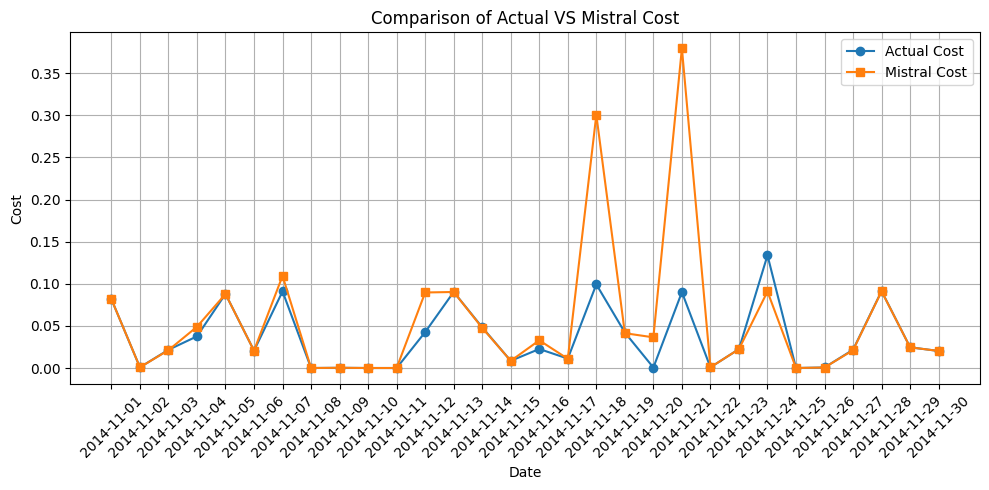

In [2]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}
import matplotlib.pyplot as plt
# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()